
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json
import re
import zipfile
import os
import sys
import pandas as pd

Cell 1:

## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

Cell 2:

# ***What?*** 

I am planning to analyze how the words “lesbian,” “gay”, “bisexual,” “queer,” and “transgender” have been used and the cultural concepts they have been associated with over time (since 1990) in the United States. I will also explore how these words are used in relation “black,” “white,” “latino” and “asian”, to see whether lgbt words have different meanings when associated with different racial groups. 

Cell 3:

## ***Why?***

Public policy relating to LGBTQ rights has changed dramatically over the last 20 years, though human rights for certain groups - black trans people, poor queer people, etc, have been ignored. I am curious to know how words describing LGBTQ people have been used over time, and if such a change reflects the evolving public opinion and public policy regarding LGBTQ rights. I will also explore whether public opinion changed public policy in this realm, or vice versa. Knowing how/whether language can change public policy could provide insight into how language can be used to push for public policy protecting marginalized LGBTQ groups today. 


Cell 4:

## ***How?***

I will use conduct network analysis, similar to what was used in HW 5 of the LGBTQ words used in the COCA corpus to do exploratory analysis. I will also train word embedding models similar to those used by Prof. James Evans in the paper “The Geometry of Culture: Analyzing Meaning through Word Embeddings” on the COCA corpus. This includes the word2vec algorithm, the fastText algorithm, and the GloVe algorithm.     

## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

Cell 6:

## ***Which (words)?***


I will be using the COCA corpora made available by Professor James Evans. The COCA corpora contains 600 million words of text (20 million words each year 1990-2019) and it is equally divided among spoken, fiction, popular magazines, newspapers, and academic texts. This provides a good sample to understand how LGBTQ vocabulary appears in popular fiction, on the news, and more informally on the web. The corpora contains text files since 1990. A reasonable path to scale this project up would be to use a corpora that starts earlier in order to study on the words have changed over a longer period of time. Another way would be to use texts from all over the globe to do a more cross-sectional comparison of how LGBTQ vocabulary has been used in different cultures.

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [5]:
corpus_name = "/Users/vedikaahuja/winter2020/Content-Analysis-2020/COCA"

In [6]:
def loadcorpus(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        if corpus_style in file:
            print(file)
            zfile = zipfile.ZipFile(corpus_name + "/" + file)
            for file in zfile.namelist():
                texts_raw[file] = []
                with zfile.open(file) as f:
                    for line in f:
                        texts_raw[file].append(line)
    return texts_raw

In [7]:
coca_raw = loadcorpus(corpus_name)

text_magazine_jex.zip
text_spoken_kde.zip
text_fiction_awq.zip
text_newspaper_lsp.zip
text_academic_rpe.zip
text_2012-2015_ksr.zip


In [8]:
len(coca_raw['w_mag_1990.txt'])

1697

In [9]:
coca_raw.keys()

dict_keys(['w_mag_1990.txt', 'w_mag_1991.txt', 'w_mag_1992.txt', 'w_mag_1993.txt', 'w_mag_1994.txt', 'w_mag_1995.txt', 'w_mag_1997.txt', 'w_mag_1998.txt', 'w_mag_1999.txt', 'w_mag_2000.txt', 'w_mag_2001.txt', 'w_mag_2002.txt', 'w_mag_2003.txt', 'w_mag_2004.txt', 'w_mag_2005.txt', 'w_mag_2006.txt', 'w_mag_2007.txt', 'w_mag_2008.txt', 'w_mag_2009.txt', 'w_mag_2010.txt', 'w_mag_2011.txt', 'w_mag_2012.txt', 'w_mag_1996.txt', 'w_spok_1990.txt', 'w_spok_1991.txt', 'w_spok_1992.txt', 'w_spok_1993.txt', 'w_spok_1994.txt', 'w_spok_1995.txt', 'w_spok_1996.txt', 'w_spok_1997.txt', 'w_spok_1998.txt', 'w_spok_1999.txt', 'w_spok_2000.txt', 'w_spok_2001.txt', 'w_spok_2002.txt', 'w_spok_2003.txt', 'w_spok_2004.txt', 'w_spok_2005.txt', 'w_spok_2006.txt', 'w_spok_2007.txt', 'w_spok_2008.txt', 'w_spok_2009.txt', 'w_spok_2010.txt', 'w_spok_2011.txt', 'w_spok_2012.txt', 'w_fic_1990.txt', 'w_fic_1991.txt', 'w_fic_1992.txt', 'w_fic_1993.txt', 'w_fic_1994.txt', 'w_fic_1995.txt', 'w_fic_1996.txt', 'w_fic_1997.

In [10]:
len(coca_raw['w_mag_1991.txt'])

1736

In [11]:
def clean_raw_text(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace("\'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d").replace("<p>", "").replace("@", "")
            clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return clean_texts

In [12]:
#only use one text file for now

In [18]:
clean_11 = clean_raw_text(coca_raw['w_mag_1990.txt'])

In [14]:
zfile = zipfile.ZipFile(corpus_name + "/sources.zip")
source = []

for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [15]:
len(source)

248951

In [13]:
coca_texts = {}
for files in coca_raw:
    if len(coca_texts) > 1000:
        break
    coca_text = clean_raw_text(coca_raw[files][1:])
    for text_list in coca_text:
        txts = lucem_illud_2020.word_tokenize(text_list)
        try:
            coca_texts[txts[0][2:]] = txts[1:]
        except IndexError:
            continue

In [16]:
len(coca_texts)

1696

In [17]:
len(coca_raw)

135

In [19]:
text_df = pd.DataFrame(columns=["title", "year", "genre", "source", "title", "text"])

In [48]:
source

'ABC_20/20'

In [45]:
source[3]

b'221118\t8101\t1990\tSPOK\t101\tABC_20/20\tIs He a Killer?; Who Will Love My Pet?; The Twilight State; Drug War Status Report\r\n'

In [46]:
 tid, num_words, year, genre, subgenre, source, title = source[3].decode("utf-8").split("\t")

In [47]:
source

'ABC_20/20'

In [52]:
len(coca_texts)

1696

In [55]:
source_tid = []
for s in source[3:]:
    try:

    tid, num_words, year, genre, subgenre, source, title = movie.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        print("error!")
        continue
    source_tid.append(tid)

SyntaxError: invalid syntax (<ipython-input-55-6fbbbe2eb1e6>, line 4)

In [50]:
for movie in source[3:]:
    print(movie)
    try:
        tid, num_words, year, genre, subgenre, source, title = movie.decode("utf-8").split("\t")
        print(tid)
    except UnicodeDecodeError:
        print("error!")
        continue
    try:
        text_df.loc[tid.strip()] = [title.strip(), year.strip(), genre.strip(), source.strip(), title.strip(), coca_texts[tid.strip()]]
    except KeyError:
        print("key error!")
        continue

b'221118\t8101\t1990\tSPOK\t101\tABC_20/20\tIs He a Killer?; Who Will Love My Pet?; The Twilight State; Drug War Status Report\r\n'
221118
key error!
b'221119\t8358\t1990\tSPOK\t101\tABC_20/20\tGolden Years Behind Bars; The Joker; Goodbye Wrinkles; The Drug War Status Report\r\n'
221119
key error!
b'221120\t7824\t1990\tSPOK\t101\tABC_20/20\tToo Old Too Soon; Danger on the Half Shell; Missing a Chance to Live?; The Drug War Status Report\r\n'
221120
key error!
b'221121\t8559\t1990\tSPOK\t101\tABC_20/20\tChicken at Any Price?; The Daytop Solution; Suffering from Tourette; The Drug War Status Report\r\n'
221121
key error!
b'221122\t8199\t1990\tSPOK\t101\tABC_20/20\tChildren of Terror; Against All Odds; Buck Fever; U.S.S. Iowa Follow-Up\r\n'
221122
key error!
b'221123\t8171\t1990\tSPOK\t101\tABC_20/20\tBittersweet Harvest; The Power of Dr. M; Palm Beach Photo Play; The Drug War Status Report\r\n'
221123
key error!
b'221124\t7994\t1990\tSPOK\t101\tABC_20/20\tWhen Anarchy Reigned; Mid-Life M

b'236982\t8264\t1990\tSPOK\t104\tCNN_Specials\tCNN_Specials / 19901025\r\n'
236982
key error!
b'237013\t5151\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900314\r\n'
237013
key error!
b'237014\t4247\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900315\r\n'
237014
key error!
b'237015\t4341\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900316\r\n'
237015
key error!
b'237016\t4438\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900319\r\n'
237016
key error!
b'237017\t5425\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900320\r\n'
237017
key error!
b'237018\t5208\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900321\r\n'
237018
key error!
b'237019\t4176\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900322\r\n'
237019
key error!
b'237020\t4194\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900323\r\n'
237020
key error!
b'237021\t4387\t1990\tSPOK\t104\tCNN_Crossfire\tCNN_Crossfire / 19900326\r\n'
237021
key error!
b'237022\t4557\t1990\tSPOK\t104\tCNN_Cross

242278
key error!
b'242279\t3652\t1991\tSPOK\t101\tABC_Nightline\tExorcism\r\n'
242279
key error!
b'242280\t3445\t1991\tSPOK\t101\tABC_Nightline\tKurdish Refugees in Desperate Situation\r\n'
242280
key error!
b'242281\t4290\t1991\tSPOK\t101\tABC_Nightline\tNancy Reagan Bio; Kennedy Sex Allegations\r\n'
242281
key error!
b"242282\t4248\t1991\tSPOK\t101\tABC_Nightline\tGulf Update; Nightline's Gulf War Political Scorecard\r\n"
242282
key error!
b"242283\t3642\t1991\tSPOK\t101\tABC_Nightline\tFormal Gulf Cease-Fire Doesn't Help Refugees\r\n"
242283
key error!
b"242284\t3813\t1991\tSPOK\t101\tABC_Nightline\tU.S. Troops' Pullout Leaves Refugees in Crisis\r\n"
242284
key error!
b'242285\t3922\t1991\tSPOK\t101\tABC_Nightline\tDid Reagan-Bush Campaign Make Hostage Deal?\r\n'
242285
key error!
b'242286\t3592\t1991\tSPOK\t101\tABC_Nightline\tBush Aid for Kurds; Late U. S. Aid to Saddam War Machine\r\n'
242286
key error!
b'242287\t3878\t1991\tSPOK\t101\tABC_Nightline\tNY Times, NBC Name Palm Beac

b'235419\t985\t1992\tSPOK\t108\tNPR_ATC\tFDIC AUCTIONS S&amp;L PROPERTY VIA SATELLITE\r\n'
235419
key error!
b'235420\t1552\t1992\tSPOK\t108\tNPR_ATC\tPACKWOOD ACCUSERS &amp; THE ETHICS INVESTIGATION\r\n'
235420
key error!
b'235421\t1063\t1992\tSPOK\t108\tNPR_ATC\tSKIN COLORS OF BLACKS MAY EQUAL DISCRIMINATIONS\r\n'
235421
key error!
b'235423\t1212\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921204\r\n'
235423
key error!
b'235424\t1491\t1992\tSPOK\t108\tNPR_ATC\tMALCOLM X MIGHT BE A CONSERVATIVE IF ALIVE\r\n'
235424
key error!
b'235425\t596\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921208\r\n'
235425
key error!
b'235428\t1934\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921214\r\n'
235428
key error!
b'235429\t1141\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921215\r\n'
235429
key error!
b'235430\t1147\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921216\r\n'
235430
key error!
b'235434\t1275\t1992\tSPOK\t108\tNPR_ATC\tNPR_ATC / 19921222\r\n'
235434
key error!
b'235435\t1296\t1992\tSPOK\t108\tNPR_ATC\tNEWS\r\n'
2

b'228748\t1397\t1993\tSPOK\t103\tCBS_FaceNation\tVICE PRESIDENT AL GORE DISCUSSES THE NORTH AMERICAN FREE TRADE AGREEMENT AND THE NEW JERSEY GOVERNOR RACE\r\n'
228748
key error!
b'228749\t1632\t1993\tSPOK\t103\tCBS_FaceNation\tREPRESENTATIVE RICHARD GEPHARDT DISCUSSES THE NORTH AMERICAN FREE TRADE AGREEMENT\r\n'
228749
key error!
b'228750\t1025\t1993\tSPOK\t103\tCBS_FaceNation\tFRED BARNES OF THE NEW REPUBLIC AND JOE KLEIN OF NEWSWEEK DISCUSS INTERNATIONAL TRADE, CRIME, THE BRADY BILL AND SENATOR BOB PACKWOOD\r\n'
228750
key error!
b'228751\t1579\t1993\tSPOK\t103\tCBS_FaceNation\tSENATOR ALAN SIMPSON OF WYOMING DISCUSSES THE BRADY BILL AND SENATOR BOB PACKWOOD\r\n'
228751
key error!
b'228752\t1641\t1993\tSPOK\t103\tCBS_FaceNation\tCOMMERCE SECRETARY RON BROWN DISCUSSES NAFTA, THE APEC MEETING AND CRIMINAL ALLEGATIONS AGAINST BROWN HIMSELF\r\n'
228752
key error!
b'228753\t4405\t1993\tSPOK\t103\tCBS_FaceNation\tPRESIDENTIAL EXPERTS GARRY WILLS, DORIS KEARNS GOODWIN, DAVID MARANISS AND RI

key error!
b'224307\t2010\t1994\tSPOK\t103\tCBS_Special\tMILITARY CEREMONY HELD IN NEW YORK FOR FORMER PRESIDENT RICHARD NIXON BEFORE HIS BODY IS FLOWN TO CALIFORNIA\r\n'
224307
key error!
b"224312\t2390\t1994\tSPOK\t103\tCBS_Special\tAMERICA'S REACTION TO PRESIDENT CLINTON'S STATE OF THE UNION ADDRESS AND INTERVIEWS ABOUT CRIME AND HEALTH-CARE REFORM\r\n"
224312
key error!
b'224329\t4256\t1994\tSPOK\t103\tCBS_Special\tUPDATE ON THE SOUTHERN CALIFORNIA EARTHQUAKE\r\n'
224329
key error!
b'224331\t7561\t1994\tSPOK\t103\tCBS_Special\tPRESIDENT CLINTON DELIVERS HIS STATE OF THE UNION ADDRESS\r\n'
224331
key error!
b'225105\t1098\t1994\tSPOK\t103\tCBS_Morning\tILLINOIS REPRESENTATIVE JIM MCPIKE, CLARK BRIDGE ENGINEER DALE KLOHR AND FLOOD VICTIM DOROTHY STRACK DISCUSS THE OPENING OF THE NEW CLARK BRIDGE BETWEEN MISSOURI AND ILLINOIS\r\n'
225105
key error!
b'225106\t1018\t1994\tSPOK\t103\tCBS_Morning\tSOAP STARS MARCY WALKER AND ROBERT NEWMAN, JOSH AND TANGIE ON "GUIDING LIGHT," DISCUSS WORKI

b'221277\t8546\t1995\tSPOK\t101\tABC_20/20\tRx For Disaster - Thousands Killed by Heart Drugs\r\n'
221277
key error!
b'221278\t8943\t1995\tSPOK\t101\tABC_20/20\tGoing Berserk - Teen Skinheads Murder Parents, Brother\r\n'
221278
key error!
b'221279\t8366\t1995\tSPOK\t101\tABC_20/20\tDivorce Through the Eyes of Your Child\r\n'
221279
key error!
b'221281\t8514\t1995\tSPOK\t101\tABC_20/20\tSo Easy, So Deadly, So Wrong - making homemade bombs\r\n'
221281
key error!
b"221282\t7546\t1995\tSPOK\t101\tABC_20/20\t'The Hunger Inside' - Update on Anorexia Therapy\r\n"
221282
key error!
b'221286\t8265\t1995\tSPOK\t101\tABC_20/20\tCashing In On America\r\n'
221286
key error!
b"221287\t7993\t1995\tSPOK\t101\tABC_20/20\tDavid Smith's Sorrow\r\n"
221287
key error!
b'221289\t7993\t1995\tSPOK\t101\tABC_20/20\tWe Want Our Children Back\r\n'
221289
key error!
b'221292\t8497\t1995\tSPOK\t101\tABC_20/20\tTruth On Trial - Could Children Lie About Sexual Abuse?\r\n'
221292
key error!
b'221293\t8312\t1995\tSPOK

235932
key error!
b"235933\t4157\t1995\tSPOK\t108\tNPR_ATC\tChicago's Washington Irving Students Go to Washington\r\n"
235933
key error!
b'235934\t1764\t1995\tSPOK\t108\tNPR_ATC\tBritain Has Its Own Oskar Schindler in Dennis Hills\r\n'
235934
key error!
b"235935\t1374\t1995\tSPOK\t108\tNPR_ATC\tU.S. POW's Died During Attacks on Japan's Fleet in WWII\r\n"
235935
key error!
b'235936\t1227\t1995\tSPOK\t108\tNPR_ATC\tIsraeli Singer Mixes Music and Comedy\r\n'
235936
key error!
b'235937\t1880\t1995\tSPOK\t108\tNPR_ATC\tPresident and Speaker Hold Historic "Dialogue"\r\n'
235937
key error!
b'235938\t1256\t1995\tSPOK\t108\tNPR_ATC\tRadical 1800s Feminist Lost in History\r\n'
235938
key error!
b'235939\t1562\t1995\tSPOK\t108\tNPR_ATC\tLawyers Disagree on Effect of Habeas Reform\r\n'
235939
key error!
b'235940\t1967\t1995\tSPOK\t108\tNPR_ATC\tArchivist Recalls Simple Days of Early Telephone Use\r\n'
235940
key error!
b'235941\t1822\t1995\tSPOK\t108\tNPR_ATC\tStudent Finds Holocaust a Vehicle for

231977
key error!
b'231978\t3510\t1996\tSPOK\t109\tInd_Limbaugh\tMISQUOTES ABOUT LIMBAUGH; OPINIONS ABOUT MRS. CLINTON; DOG HAVING FAKE TESTICLES; ROSS PEROT POSSIBLY RUNNING FOR PRESIDENT\r\n'
231978
key error!
b"231979\t3393\t1996\tSPOK\t109\tInd_Limbaugh\tWHOOPI GOLDBERG'S RESPONSE TO REVEREND JACKSON'S PROTEST OF ACADEMY AWARDS; CLINTONS SUPPORT BOSNIAN TROOPS WHILE CONDEMNING MILITARY AS A WHOLE; RAISING AMERICA'S MINIMUM WAGE\r\n"
231979
key error!
b"231980\t3144\t1996\tSPOK\t109\tInd_Limbaugh\tPEROT GIVES SPEECH IN TEXAS ON HIS REFORM PARTY; AMERICAN SUCCESS STORIES; MARY MATALIN'S CAMPAIGN SLOGANS FOR DOLE; PHARMACEUTICAL COMPANY INTRODUCES NICOTINE NASAL SPRAY OTC\r\n"
231980
key error!
b'231981\t3452\t1996\tSPOK\t109\tInd_Limbaugh\tSENATE CAFETERIA WORKER REMOVED FOR CHARGES OF SEXUAL HARASSMENT FOR USING PET NAMES; PEROT LOSES SUPPORT OF PEOPLE MOST LIKELY TO VOTE; CLINTON SPEAKS ON CAMPAIGN ISSUES\r\n'
231981
key error!
b'231982\t3300\t1996\tSPOK\t109\tInd_Limbaugh\tITEMS F

226170
key error!
b'226171\t994\t1997\tSPOK\t103\tCBS_Morning\tCO-OP TIME\r\n'
226171
key error!
b'226172\t1081\t1997\tSPOK\t103\tCBS_Morning\tCO-OP TIME\r\n'
226172
key error!
b'226173\t1820\t1997\tSPOK\t103\tCBS_Morning\tFRED, PATTI AND KIM GOLDMAN DISCUSS GETTING THE NEWS OF RON\'S DEATH; THE CRIMINAL AND CIVIL TRIALS; COPING WITH THE LOSS; THEIR NEW BOOK, "HIS NAME IS RON: OUR SEARCH FOR JUSTICE"\r\n'
226173
key error!
b'226174\t1104\t1997\tSPOK\t103\tCBS_Morning\tCO-OP TIME\r\n'
226174
key error!
b"226175\t1070\t1997\tSPOK\t103\tCBS_Morning\tJEFF PUCCI OF VIRTUAL ENTERTAINMENT AND CAROL TOMLINSON OF THE NATIONAL ASSOCIATION FOR GIFTED CHILDREN DISCUSS A NEW CHILDREN'S IQ TEST ON CD-ROM\r\n"
226175
key error!
b'226176\t1205\t1997\tSPOK\t103\tCBS_Morning\tAUTHOR WALTER MOSLEY DISCUSSES HIS NEW BOOK, "GONE FISHIN\'"\r\n'
226176
key error!
b'226177\t1079\t1997\tSPOK\t103\tCBS_Morning\tCO-OP TIME\r\n'
226177
key error!
b'226178\t1864\t1997\tSPOK\t103\tCBS_Morning\tFORMER LAPD DETECTIVE

221867
key error!
b'221868\t940\t1998\tSPOK\t103\tCBS_48Hours\tSOMEWHERE OUT THERE; CHERYL LAMARE HIRES COMMANDOS TO HELP RESCUE HER DAUGHTER\r\n'
221868
key error!
b'221869\t1544\t1998\tSPOK\t103\tCBS_48Hours\tTWEEKER; CHRISTINE CALNEK, WHO STARTED USING METHAMPHETAMINES AT AGE 12\r\n'
221869
key error!
b'221870\t1377\t1998\tSPOK\t103\tCBS_48Hours\tWOMEN WHO USED METHAMPHETAMINES WHILE PREGNANT FEAR BIRTH DEFECTS\r\n'
221870
key error!
b'221871\t1177\t1998\tSPOK\t103\tCBS_48Hours\tUNDER SIEGE; RIVERSIDE DEPUTY DISTRICT ATTORNEY DICK NIXON HANDLES METHAMPHETAMINE-RELATED CASES TO SPEED UP COURT SYSTEM\r\n'
221871
key error!
b'221872\t1174\t1998\tSPOK\t103\tCBS_48Hours\tFAST TIMES; FOUR MEN TRY TO RECOVER FROM ADDICTION TO METHAMPHETAMINES\r\n'
221872
key error!
b'221873\t1146\t1998\tSPOK\t103\tCBS_48Hours\tNO PLACE LIKE HOME; HOW HURRICANE ANDREW OF 1992 CHANGED THE LIVES OF FLORIDA RESIDENTS\r\n'
221873
key error!
b"221874\t1080\t1998\tSPOK\t103\tCBS_48Hours\tDEWEY'S COURAGE; SEVEN-YE

233892
key error!
b'233893\t7207\t1998\tSPOK\t109\tInd_Geraldo\tPANELISTS DISCUSS WHETHER JAMES EARL RAY IS GUILTY OF KILLING MARTIN LUTHER KING JR.; JAMES EARL RAY DENIES MURDER\r\n'
233893
key error!
b'233894\t8150\t1998\tSPOK\t109\tInd_Geraldo\tCELEBRITIES: COMING BACK FROM SCANDAL; PANELISTS DISCUSS THE REDEMPTION IN THEIR LIVES AND THE FALL FROM GRACE IN THE EYES OF THE PUBLIC\r\n'
233894
key error!
b'233895\t9483\t1998\tSPOK\t109\tInd_Geraldo\tFROM PRESIDENTS TO PAUPERS: WHY MEN FLIRT; FINE ART OF FLIRTING, IS IT POLITICALLY CORRECT, HOW BOTH MEN AND WOMEN USE FLIRTING TO GET WHAT THEY WANT\r\n'
233895
key error!
b"233896\t7249\t1998\tSPOK\t109\tInd_Geraldo\tLOVERS &amp; MURDER; GUESTS TALK ABOUT LOVED ONES THEY'VE LOST TO VENGEFUL HUSBANDS AND BOYFRIENDS\r\n"
233896
key error!
b'233897\t7223\t1998\tSPOK\t109\tInd_Geraldo\tMEDIA, MAYHEM &amp; MURDER; THE INFLUENCE OF MUSIC, MOVIES AND MEDIA MAY BE CONNECTED TO ACTS OF SEX, VIOLENCE AND SUICIDE IN ADOLESCENTS\r\n'
233897
key error

227299
key error!
b'227303\t4084\t1999\tSPOK\t104\tCNN_Company\tIs Y2K Bugging You?\r\n'
227303
key error!
b'227304\t3476\t1999\tSPOK\t104\tCNN_Company\tKosovar High Schoolers Tell Their Stories and Look to the Future\r\n'
227304
key error!
b'227305\t3847\t1999\tSPOK\t104\tCNN_Company\tDo Reform Party Defections Signal New Era in American Politics?\r\n'
227305
key error!
b"227403\t3722\t1999\tSPOK\t104\tCNN_Burden\tInvestigators Continue Search for 'Railway Killer'\r\n"
227403
key error!
b'227404\t4002\t1999\tSPOK\t104\tCNN_Burden\tKennedy Crash Investigation: Deciphering the Final Moments of That Fatal Flight and the Safety of Small Aircraft\r\n'
227404
key error!
b"227405\t4157\t1999\tSPOK\t104\tCNN_Burden\tCarolyn Bessette Kennedy's Mother Files Court Papers: What are the Estate Laws and Do Lawsuits Lie Ahead\r\n"
227405
key error!
b"227406\t2169\t1999\tSPOK\t104\tCNN_Burden\tAre the Aisenbergs Responsible for Baby Sabrina's Death?\r\n"
227406
key error!
b"227407\t3677\t1999\tSPOK\t

b"238951\t1349\t1999\tSPOK\t108\tNPR_Morning\tSKIP SPENCE'S SHORT-LIVED MUSIC CAREER RESULTED IN ONE SOLO ALBUM, WHICH IS BEING REMASTERED IN TRIBUTE TO HIM\r\n"
238951
key error!
b'238952\t1409\t1999\tSPOK\t108\tNPR_Morning\tCHARLES OSGOOD OF CBS TALKS ABOUT HIS WORK ON BOTH RADIO AND TELEVISION\r\n'
238952
key error!
b'238954\t954\t1999\tSPOK\t108\tNPR_Morning\tHOW SOUTH CAROLINA WEATHERED HURRICANE FLOYD\r\n'
238954
key error!
b'238955\t1167\t1999\tSPOK\t108\tNPR_Morning\tSINGER-SONGWRITER KRIS KRISTOFFERSON DISCUSSES HIS NEW CD "THE AUSTIN SESSIONS" AND TALKS ABOUT SOME OF HIT SONGS HE\'S WRITTEN AND RECORDED\r\n'
238955
key error!
b"238956\t1311\t1999\tSPOK\t108\tNPR_Morning\tJOHN PIERCE, PUBLISHER OF THE OLD FARMER'S ALMANAC, ON INFORMATION AVAILABLE WITHIN ITS CONTENTS\r\n"
238956
key error!
b'238957\t1542\t1999\tSPOK\t108\tNPR_Morning\tDEBATE BETWEEN VICE PRESIDENT AL GORE AND FORMER SENATOR BILL BRADLEY IN NEW HAMPSHIRE\r\n'
238957
key error!
b'238960\t1096\t1999\tSPOK\t108\tN

key error!
b'107095\t601\t2000\tSPOK\t108\tNPR_Morning\tProfile: Florida judge rules that the great-uncle of Elian Gonzalez will be granted temporary custody of the six-year-old until a hearing is held in March\r\n'
107095
key error!
b'107096\t856\t2000\tSPOK\t108\tNPR_Morning\tProfile: Three Chinese stowaways found dead after a three-week journey to the US in a cargo container\r\n'
107096
key error!
b'107097\t609\t2000\tSPOK\t108\tNPR_Morning\tProfile: Education conference to discuss teacher training and alleviate the shortage of teachers\r\n'
107097
key error!
b"107098\t728\t2000\tSPOK\t108\tNPR_Morning\tAnalysis: Contract dispute between the women's World Cup soccer team and the US Soccer Federation\r\n"
107098
key error!
b'107099\t1449\t2000\tSPOK\t108\tNPR_Morning\tProfile: Supreme Court to focus on the rights of grandparents\r\n'
107099
key error!
b"107193\t590\t2000\tSPOK\t108\tNPR_Morning\tProfile: Possibility that India's best-known tiger has fallen prey to poachers\r\n"
10719

173788
key error!
b"173790\t4222\t2000\tSPOK\t104\tCNN_Crossfire\tWill Michigan's Republican Primary Determine the GOP's Nominee?\r\n"
173790
key error!
b'173791\t3689\t2000\tSPOK\t104\tCNN_Crossfire\tWhy Are So Many Independents and Democrats Supporting John McCain?\r\n'
173791
key error!
b"173792\t4258\t2000\tSPOK\t104\tCNN_Crossfire\tWho Is the `Right' Choice for South Carolina Republicans?\r\n"
173792
key error!
b'173793\t4051\t2000\tSPOK\t104\tCNN_Crossfire\tGovernor Jesse Ventura Leaps Out of Reform Party Ring\r\n'
173793
key error!
b'173794\t4118\t2000\tSPOK\t104\tCNN_Crossfire\tShould It Be Legal to Buy Human Eggs?\r\n'
173794
key error!
b"173795\t4069\t2000\tSPOK\t104\tCNN_Crossfire\tWill John McCain's Message Appeal to Voters in the Next Primary States?\r\n"
173795
key error!
b'173796\t4699\t2000\tSPOK\t104\tCNN_Crossfire\tWill New Hampshire Pick the Next President of the United States?\r\n'
173796
key error!
b"173797\t4373\t2000\tSPOK\t104\tCNN_Crossfire\tWho's Positioned to

b'7098\t2870\t2001\tSPOK\t105\tFox_HC\tIs It Easier for Democrats to Get Away With Racism Than Republicans?\r\n'
7098
key error!
b'7099\t1338\t2001\tSPOK\t105\tFox_HC\tDoes the Bush Tax Plan Go Far Enough?\r\n'
7099
key error!
b'7197\t1290\t2001\tSPOK\t105\tFox_HC\tWas Stripper/Athlete Leilani Rios Unfairly Tossed off Her Track Team for Tossing off Her Clothes?\r\n'
7197
key error!
b'7198\t1732\t2001\tSPOK\t105\tFox_HC\tShould U.S. Attorney General John Ashcroft Use His Office to Spread the Word of God?\r\n'
7198
key error!
b'7199\t2551\t2001\tSPOK\t105\tFox_HC\tIs Cincinnati a Racial Time Bomb Waiting to Explode?\r\n'
7199
key error!
b'7297\t1350\t2001\tSPOK\t105\tFox_HC\tDoes Robert Redford Owe Gale Norton an Apology?\r\n'
7297
key error!
b'7298\t1630\t2001\tSPOK\t105\tFox_HC\tAre African-American Leaders in Cincinnati Turning a Blind Eye to Black-on-Black Violence?\r\n'
7298
key error!
b'7299\t925\t2001\tSPOK\t105\tFox_HC\tOne-on-One With Keith Watters\r\n'
7299
key error!
b'7398\t2

111196
key error!
b"111197\t587\t2001\tSPOK\t108\tNPR_Morning\tAnalysis: Democrats and Republicans alike applaud Bush's pick for US Trade representative\r\n"
111197
key error!
b'111198\t576\t2001\tSPOK\t108\tNPR_Morning\tInterview: Sue Bostrom talks about how the current focus on layoffs in the tech industry is inaccurate\r\n'
111198
key error!
b'111199\t780\t2001\tSPOK\t108\tNPR_Morning\tProfile: AOL-Time Warner merger receives final OK, but not without some stipulations\r\n'
111199
key error!
b"111295\t913\t2001\tSPOK\t108\tNPR_Morning\tProfile: Artist Tina Mion's works of presidents and first ladies on display\r\n"
111295
key error!
b'111296\t903\t2001\tSPOK\t108\tNPR_Morning\tAnalysis: California now facing a home-heating crisis, in addition to the electricity crisis\r\n'
111296
key error!
b'111297\t598\t2001\tSPOK\t108\tNPR_Morning\tAnalysis: Capture of four of the seven convicts who broke out of a Texas prison\r\n'
111297
key error!
b'111298\t1206\t2001\tSPOK\t108\tNPR_Morning\tI

b'178897\t12356\t2001\tSPOK\t104\tCNN_Politics\tSingle Senator Turns Washington Politics Upside Down; Senate Passes $1.35 Trillion Tax Cut\r\n'
178897
key error!
b'178898\t11703\t2001\tSPOK\t104\tCNN_Politics\tRepublican Senator Jeffords Considering Switching Parties; Democrats Delay Tax Cut\r\n'
178898
key error!
b'178999\t11505\t2001\tSPOK\t104\tCNN_Politics\tPresident Clinton Orders Millions of Acres of Federal Land Protected From Development; President-elect Likely to Review Decision\r\n'
178999
key error!
b'180097\t1038\t2001\tSPOK\t104\tCNN_Daybreak\tDoctors Without Borders Returns to Kabul\r\n'
180097
key error!
b'180098\t1586\t2001\tSPOK\t104\tCNN_Daybreak\tSailor Falls Overboard as U.S. Strikes Continue in Afghanistan\r\n'
180098
key error!
b"180099\t1169\t2001\tSPOK\t104\tCNN_Daybreak\tThe Symbolism Behind King Abdullah's Visit to England\r\n"
180099
key error!
b"180197\t1346\t2001\tSPOK\t104\tCNN_Daybreak\tJournalists Describe 'Symbolic Kidnapping' in Israel\r\n"
180197
key 

23098
b'23099\t479\t2002\tSPOK\t103\tCBS_Rather\tAmerica Views New 9/11 Footage \r\n'
23099
b'23191\t340\t2002\tSPOK\t103\tCBS_Rather\tMore Churches in Scandal \r\n'
23191
key error!
b'23192\t501\t2002\tSPOK\t103\tCBS_Rather\tGeography of War-torn Territories \r\n'
23192
key error!
b'23193\t444\t2002\tSPOK\t103\tCBS_Rather\tFt. Drum Troops Go Home \r\n'
23193
key error!
b'23194\t476\t2002\tSPOK\t103\tCBS_Rather\tCincinnati Settles, Blacks Continue Boycott \r\n'
23194
key error!
b'23195\t1090\t2002\tSPOK\t103\tCBS_Rather\tMiddle East Violence, Protests Intensify \r\n'
23195
key error!
b'23196\t908\t2002\tSPOK\t103\tCBS_Rather\tKing Abdullah Interview \r\n'
23196
key error!
b'23197\t1233\t2002\tSPOK\t103\tCBS_Rather\tIsrael Leaves Two West Bank Cities \r\n'
23197
key error!
b'23198\t368\t2002\tSPOK\t103\tCBS_Rather\tCommon Cold May Fight Cancer \r\n'
23198
key error!
b'23199\t367\t2002\tSPOK\t103\tCBS_Rather\tPump Prices Continue to Rise \r\n'
23199
key error!
b'23291\t370\t2002\tSPOK\t1

key error!
b"137162\t206\t2002\tSPOK\t108\tNPR_TalkNation\tAnalysis: President Bush's plan for provisional Palestinian statehood\r\n"
137162
key error!
b"137163\t247\t2002\tSPOK\t108\tNPR_TalkNation\tInterview: Don Phillips discusses Amtrak's financial problems and whether the passenger railroad has a future\r\n"
137163
key error!
b'137165\t118\t2002\tSPOK\t108\tNPR_TalkNation\tAnalysis: History of women in American espionage\r\n'
137165
key error!
b'137166\t249\t2002\tSPOK\t108\tNPR_TalkNation\tAnalysis: Evolution of the death penalty in America\r\n'
137166
key error!
b'137167\t913\t2002\tSPOK\t108\tNPR_TalkNation\tInterview: Jim Glassman discusses the Dow going below the 9,000 mark and the accounting scandal at WorldCom\r\n'
137167
key error!
b"137168\t182\t2002\tSPOK\t108\tNPR_TalkNation\tAnalysis: This summer's box-office fare\r\n"
137168
key error!
b'137169\t251\t2002\tSPOK\t108\tNPR_TalkNation\tAnalysis: Debate on separation of church and state flares up, fueled by recent court d

b'206678\t6526\t2002\tSPOK\t104\tCNN_Next\tHackers Sell Stolen Information in Chat Rooms; IBM Develops Device to Bridge Cultural Gaps; Iceland Looks For Clean Source of Energy\r\n'
206678
key error!
b'206679\t6416\t2002\tSPOK\t104\tCNN_Next\tRecognizing Unsung Heroes of Movies; Canadian Town Deals With Wayward Elk; New Evidence Humanity Evolved From One Pre-Human Species\r\n'
206679
key error!
b'206680\t6355\t2002\tSPOK\t104\tCNN_Next\tEl Nino Is Coming Back; A Unique Way to Train Firefighters; Tiger Woods, Britney Spears Come Out With New Video Games\r\n'
206680
key error!
b'206681\t6359\t2002\tSPOK\t104\tCNN_Next\tCutting Edge Innovations at Tech Conference in Phoenix; Millions of Monarch Butterflies Drop Dead in Mexico; New Yorkers Do Math on the Street\r\n'
206681
key error!
b'206683\t6925\t2002\tSPOK\t104\tCNN_Next\tIs Space Tourism the Next Big Thing?; Science Produces Rodent Whose Muscles Do Not Age; Unemployed Dot-Commer Turns His Life Into Cartoon\r\n'
206683
key error!
b'2072

b'43296\t1454\t2003\tSPOK\t102\tNBC_Today\tJean Chatzky gives advice to Lynn Glazewski and viewers on buying first home\r\n'
43296
key error!
b'43297\t1201\t2003\tSPOK\t102\tNBC_Today\tActor Seth Green, "The Italian Job," talks about his role as a computer hacker and upcoming projects\r\n'
43297
key error!
b'43298\t1291\t2003\tSPOK\t102\tNBC_Today\tRegena Thomashauer, "Mama Gena\'s Owner\'s and Operator\'s Guide to Men," discusses how women can get the relationship they want\r\n'
43298
key error!
b'43299\t1308\t2003\tSPOK\t102\tNBC_Today\tBehind-the-scenes look at The New York City Ballet\'s new performance, "Carnival of the Animals"\r\n'
43299
key error!
b'43396\t1446\t2003\tSPOK\t102\tNBC_Today\tDr. Ruth Peters gives suggestions on standing firm with a child who constantly begs\r\n'
43396
key error!
b'43397\t915\t2003\tSPOK\t102\tNBC_Today\tEntertainment Weekly\'s David Karger discusses "Finding Nemo" taking first place at the weekend box office and the other movies that have fallen 

key error!
b'138297\t502\t2003\tSPOK\t108\tNPR_TalkNation\tAnalysis: Veterans History Project\r\n'
138297
key error!
b'138298\t221\t2003\tSPOK\t108\tNPR_TalkNation\tAnalysis: Use of nutrition labeling and whether a new bill to require restaurants to label food would help consumers\r\n'
138298
key error!
b'138299\t312\t2003\tSPOK\t108\tNPR_TalkNation\tInterview: Yuki Noguchi discusses the FCC rule changes that allow landline phone owners to keep their numbers going to wireless\r\n'
138299
key error!
b'138372\t270\t2003\tSPOK\t108\tNPR_TalkNation\tAnalysis: Kindness of strangers\r\n'
138372
key error!
b'138373\t221\t2003\tSPOK\t108\tNPR_TalkNation\tAnalysis: Latest developments in birth control\r\n'
138373
key error!
b"138374\t947\t2003\tSPOK\t108\tNPR_TalkNation\tInterview: T.M. Sell discusses Boeing's plans to market a new plane later today, the 7E7 Dreamliner\r\n"
138374
key error!
b'138375\t175\t2003\tSPOK\t108\tNPR_TalkNation\tAnalysis: Qualities that make a great chef\r\n'
138375
k

key error!
b'186495\t414\t2003\tSPOK\t104\tCNN_Daybreak\tOpening of First D.C. Area Sniper Trial\r\n'
186495
key error!
b'186496\t392\t2003\tSPOK\t104\tCNN_Daybreak\tGrocery Clerks Walking Picket Lines in Southern California\r\n'
186496
key error!
b"186497\t519\t2003\tSPOK\t104\tCNN_Daybreak\t'Coffey Talk'\r\n"
186497
key error!
b'186498\t135\t2003\tSPOK\t104\tCNN_Daybreak\tCar Bombing at Baghdad Police Station Kills Eight\r\n'
186498
key error!
b'186499\t906\t2003\tSPOK\t104\tCNN_Daybreak\tElection Day in California\r\n'
186499
key error!
b'186695\t435\t2003\tSPOK\t104\tCNN_Daybreak\tSkinny on Trans Fats\r\n'
186695
key error!
b'186696\t641\t2003\tSPOK\t104\tCNN_Daybreak\tWhere Does President Bush Stand with American People?\r\n'
186696
key error!
b'186697\t310\t2003\tSPOK\t104\tCNN_Daybreak\tMorning Coffey\r\n'
186697
key error!
b"186698\t926\t2003\tSPOK\t104\tCNN_Daybreak\tSpielberg's Star and Weekend Box Office Movies\r\n"
186698
key error!
b'186795\t322\t2003\tSPOK\t104\tCNN_Daybr

47898
key error!
b'47899\t1352\t2004\tSPOK\t102\tNBC_Today\tStyle expert Steven Cojocaru discusses the latest celebrity trends\r\n'
47899
key error!
b'47996\t1158\t2004\tSPOK\t102\tNBC_Today\tChef Charlie Palmer and Almost Famous Chef Stephen Gillanders prepare a salmon dish\r\n'
47996
key error!
b"47997\t1489\t2004\tSPOK\t102\tNBC_Today\tAvril Graham of Harper's Bazaar magazine discusses faux fur fashions\r\n"
47997
key error!
b'47998\t762\t2004\tSPOK\t102\tNBC_Today\tMolly Sims and Carson Daly discuss the 2004 Annual Radio Music Awards held in Las Vegas\r\n'
47998
key error!
b"47999\t933\t2004\tSPOK\t102\tNBC_Today\tVice President and Mrs. Cheney discuss how the administration's run the war on terror\r\n"
47999
key error!
b'48096\t1015\t2004\tSPOK\t102\tNBC_Today\tTom Brokaw discusses the upcoming election and past elections\r\n'
48096
key error!
b'48097\t898\t2004\tSPOK\t102\tNBC_Today\tLaura Bush discusses being on the campaign trail, their plans for Election Day, and the campaigni

b"144299\t677\t2004\tSPOK\t108\tNPR_Sunday\tAnalysis: Effects on family members of NASA's scientists and engineers for Mars rovers\r\n"
144299
key error!
b'144379\t743\t2004\tSPOK\t108\tNPR_Sunday\tProfile: Remembering Justin Eyerly\r\n'
144379
key error!
b'144380\t1178\t2004\tSPOK\t108\tNPR_Sunday\tInterview: Roberto Suro discusses Latino employment trends\r\n'
144380
key error!
b'144381\t1039\t2004\tSPOK\t108\tNPR_Sunday\tProfile: Michael Elkes decides to have children without a partner\r\n'
144381
key error!
b"144382\t837\t2004\tSPOK\t108\tNPR_Sunday\tAnalysis: Listeners' comments\r\n"
144382
key error!
b'144383\tNULL\t2004\tSPOK\t108\tNPR_Sunday\tInterview: Aimee Mann discusses what she will be reading this summer\r\n'
144383
key error!
b'144384\t2503\t2004\tSPOK\t108\tNPR_Sunday\tProfile: Making a short film in 48 hours\r\n'
144384
key error!
b'144385\t392\t2004\tSPOK\t108\tNPR_Sunday\tAnalysis: Voices in the news this past week\r\n'
144385
key error!
b"144386\t664\t2004\tSPOK\t10

key error!
b'16899\t3819\t2005\tSPOK\t105\tFox_Sunday\tFOX News Sunday Roundtable\r\n'
16899
key error!
b'17129\t1010\t2005\tSPOK\t105\tFox_Saturday\tRussia Gives ABC the Boot\r\n'
17129
key error!
b'17130\t1396\t2005\tSPOK\t105\tFox_Saturday\t"Quick Takes" on the Media\r\n'
17130
key error!
b"17131\t1277\t2005\tSPOK\t105\tFox_Saturday\tMedia Covers Grieving Mother''s Vigil\r\n"
17131
key error!
b'17132\t1485\t2005\tSPOK\t105\tFox_Saturday\t"Quick Takes" on the Media\r\n'
17132
key error!
b'17133\t1380\t2005\tSPOK\t105\tFox_Saturday\tAre Media Covering Progress Being Made in Iraq?\r\n'
17133
key error!
b'17134\t1032\t2005\tSPOK\t105\tFox_Saturday\tCoverage of Gaza Pullout\r\n'
17134
key error!
b'17135\t1323\t2005\tSPOK\t105\tFox_Saturday\t2 TV Stations Refuse To Show Pro-Sheehan Ad\r\n'
17135
key error!
b'17136\t1358\t2005\tSPOK\t105\tFox_Saturday\tDid Media Overdo Coverage of Robertson Remark?\r\n'
17136
key error!
b'17137\t1295\t2005\tSPOK\t105\tFox_Saturday\t"Quick Takes" on the Med

b'128597\t869\t2005\tSPOK\t108\tNPR_Morning\tAnalysis: Some of the factors contributing to the growth of audio books\r\n'
128597
key error!
b'128598\t312\t2005\tSPOK\t108\tNPR_Morning\tAnalysis: US trade deficit and weak dollar possibly causing a worldwide correction, hurting economies in every part of the globe\r\n'
128598
key error!
b'128599\t681\t2005\tSPOK\t108\tNPR_Morning\tAnalysis: Douglas Feith resigning from the Defense Department\r\n'
128599
key error!
b'128697\t727\t2005\tSPOK\t108\tNPR_Morning\tProfile: Proposed legislation to limit class-action lawsuits\r\n'
128697
key error!
b'128698\t647\t2005\tSPOK\t108\tNPR_Morning\tInterview: Peter Richmond gives his prediction for the Super Bowl\r\n'
128698
key error!
b'128699\t587\t2005\tSPOK\t108\tNPR_Morning\tAnalysis: World Health Organization has announced there will be a massive shortfall of a powerful malaria drug in the coming year\r\n'
128699
key error!
b'128797\t612\t2005\tSPOK\t108\tNPR_Morning\tAnalysis: New Justice Depar

207694
key error!
b'207695\t8321\t2005\tSPOK\t104\tCNN_Showbiz\tFans, Celebs React to Michael Jackson Trial; "Mr. and Mrs. Smith" Director Dishes on Movie; Apple Offers iPod Refunds\r\n'
207695
key error!
b'207696\t8108\t2005\tSPOK\t104\tCNN_Showbiz\tShowbiz Tonight for June 1st, 2005, CNNHN\r\n'
207696
key error!
b'207697\t8092\t2005\tSPOK\t104\tCNN_Showbiz\tMichael Jackson`s Fate Likely to Be in Jury`s Hands Next Week; Who Will Cash in on Deep Throat Revelation?\r\n'
207697
key error!
b'207698\t7571\t2005\tSPOK\t104\tCNN_Showbiz\tRoyal Couple Visits America; Former "Price is Right" Model Wins Lawsuit; Secret Pasts of Celebs on Soaps\r\n'
207698
key error!
b'207699\t7247\t2005\tSPOK\t104\tCNN_Showbiz\tCountry Sensation Miranda Lambert Shares Secrets to Success, Jason Alexander Writes Children`s Book\r\n'
207699
key error!
b'207793\t7843\t2005\tSPOK\t104\tCNN_Showbiz\tShowbiz Tonight for August 24, 2005, CNNHN\r\n'
207793
key error!
b'207794\t8073\t2005\tSPOK\t104\tCNN_Showbiz\tShowbiz

104398
key error!
b'104399\t912\t2006\tSPOK\t108\tNPR_ATC\tAnalysis: Workers step up efforts to rescue West Virginia miners\r\n'
104399
key error!
b'104495\t564\t2006\tSPOK\t108\tNPR_ATC\tProfile: Private Jason Hasenauer, soldier in Afghanistan\r\n'
104495
key error!
b"104496\t1210\t2006\tSPOK\t108\tNPR_ATC\tProfile: Born in the '50s, beliefs now and then\r\n"
104496
key error!
b'104497\t902\t2006\tSPOK\t108\tNPR_ATC\tAnalysis: Plan allows controversial rebuilding in New Orleans\r\n'
104497
key error!
b'104498\t696\t2006\tSPOK\t108\tNPR_ATC\tAnalysis: New Orleans evacuee makes new life in Arkansas\r\n'
104498
key error!
b"104499\t741\t2006\tSPOK\t108\tNPR_ATC\tInterview: Lou Jogmen on signs in Chicago suburb stressing the meaning of `stop'\r\n"
104499
key error!
b'104595\t365\t2006\tSPOK\t108\tNPR_ATC\tAnalysis: Massachusetts court rules to remove girl from life support\r\n'
104595
key error!
b'104596\t521\t2006\tSPOK\t108\tNPR_ATC\tAnalysis: California beaches battling massive sewage 

key error!
b'167696\t8731\t2006\tSPOK\t106\tMSNBC_Matt\t_Matthews20060515\r\n'
167696
key error!
b'167697\t8806\t2006\tSPOK\t106\tMSNBC_Matt\t_Matthews20060516\r\n'
167697
key error!
b'167698\t7964\t2006\tSPOK\t106\tMSNBC_Matt\t_Matthews20060517\r\n'
167698
key error!
b'167699\t8717\t2006\tSPOK\t106\tMSNBC_Matt\t_Matthews20060518\r\n'
167699
key error!
b'168097\t8114\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060322\r\n'
168097
key error!
b'168098\t8408\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060323\r\n'
168098
key error!
b'168099\t7948\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060324\r\n'
168099
key error!
b'168197\t7781\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060824\r\n'
168197
key error!
b'168198\t8099\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060825\r\n'
168198
key error!
b'168199\t7598\t2006\tSPOK\t106\tMSNBC_Olbermann\t_Olbermann20060828\r\n'
168199
key error!
b'168493\t8201\t2006\tSPOK\t106\tMSNBC_Scarb\t_Scarborough20060419\r\n'
168493
key error!
b'1

b'246647\t994\t2007\tSPOK\t102\tNBC_Today\tDentist Susanne Cohen speaks about bad breath\r\n'
246647
key error!
b"246648\t1088\t2007\tSPOK\t102\tNBC_Today\tPsychiatrist Keith Ablow speaks about astronaut Lisa Nowak's unusual behavior\r\n"
246648
key error!
b"246649\t796\t2007\tSPOK\t102\tNBC_Today\tNBC's Today show, 9:00 AM\r\n"
246649
key error!
b"246650\t1380\t2007\tSPOK\t102\tNBC_Today\tE-mail responses to last week's story on moms who have cocktails at their children's playdates\r\n"
246650
key error!
b'246651\t1613\t2007\tSPOK\t102\tNBC_Today\tMarriage Today; Question of whether marriage counseling works; Patricia Love and Steve Stosny, authors of "How To Improve Your Marriage Without Talking About It," discuss subject\r\n'
246651
key error!
b'246652\t1263\t2007\tSPOK\t102\tNBC_Today\tAstronaut Lisa Nowak charged with attempted murder; Dr. Keith Ablow talks about what makes some people snap\r\n'
246652
key error!
b'246653\t1401\t2007\tSPOK\t102\tNBC_Today\tAuthors Michael Eric Dys

key error!
b'4025138\t2607\t2008\tSPOK\t101\tABC_20/20\tHAPPINESS;  POSITIVE PSYCHOLOGY: THE SCIENCE OF HAPPINESS\r\n'
4025138
key error!
b'4025140\t4131\t2008\tSPOK\t101\tABC_ThisWeek\t Hello , again . Our headliner this morning is never shy about speaking his mind\r\n'
4025140
key error!
b'4025148\t2107\t2008\tSPOK\t103\tCBS_Sixty\tA 26-Year Secret; Alton Logan spent 26 years behind bars for a crime he didn^t commit and with two attorneys knowing he was innocent\r\n'
4025148
key error!
b'4025151\t1981\t2008\tSPOK\t102\tNBC_Today\tJudah Friedlander, "30 Rock," discusses the show and his life\r\n'
4025151
key error!
b'4025159\t6958\t2008\tSPOK\t102\tNBC_Dateline\tBlood Brothers; Brothers Rob and Andrew Kissel both murdered and found in basements three years and 8,000 miles apart\r\n'
4025159
key error!
b'4025160\t3255\t2008\tSPOK\t108\tNPR_TellMore\tWoman Tells Of Being ^Young, Beautiful and HIV Positive^\r\n'
4025160
key error!
b'4025206\t5732\t2008\tSPOK\t108\tNPR_TalkNation\tGuantan

4071997
key error!
b'4071998\t7634\t2009\tSPOK\t102\tNBC_Dateline\tThe Detective^s Daughter; Denise Amber Lee kidnapped and murdered, despite phone calls to 911\r\n'
4071998
key error!
b'4071999\t8593\t2009\tSPOK\t102\tNBC_MeetPress\tSecretary of State <A class=RemoteLink href="search/XMLCrossLinkSearch.do?bct=A&amp;risb=21_T9804403284&amp;returnToId=20_T9804405356&amp;csi=157446&amp;A=0.5548920907874837&amp;sourceCSI=9369&amp;ind\r\n'
4071999
key error!
b'4072000\t4120\t2009\tSPOK\t102\tNBC_Matthews\tMichele Norris from NPR^s "All Things Considered," Michael Duffy from Time magazine, Ceci Connolly from <A class=RemoteLink href="search/XMLCrossLinkSearch.do?bct=A&amp;risb=21_T9804403284&amp;returnT\r\n'
4072000
key error!
b'4072001\t6853\t2009\tSPOK\t102\tNBC_Dateline\tThe Mystery of the Lost Weekend; Investigation and trial of Vincent Brothers for murder of his wife and three children\r\n'
4072001
key error!
b'4072002\t6390\t2009\tSPOK\t102\tNBC_Dateline\tKidnapped Heiress: The Patty 

key error!
b'4082351\t3857\t2010\tSPOK\t105\tFox_Journal\tJOURNAL EDITORIAL REPORT for November 13, 2010\r\n'
4082351
key error!
b'4082353\t2070\t2010\tSPOK\t105\tFox_Hannity\tThe Great American Panel\r\n'
4082353
key error!
b'4082354\t2888\t2010\tSPOK\t105\tFox_OReilly\tTalking Points Memo and Top Story\r\n'
4082354
key error!
b'4082355\t2262\t2010\tSPOK\t105\tFox_Baier\t<A class=RemoteLink href="search/XMLCrossLinkSearch.do?bct=A&amp;risb=21_T11651258969&amp;returnToId=20_T11651319902&amp;csi=174179&amp;A=0.7420913848669266&amp;sourceCSI=3652&amp;indexTerm=%23CC0002R\r\n'
4082355
key error!
b'4082356\t3615\t2010\tSPOK\t108\tNPR_TellMore\tTea Party Influence Next Congress Hard To Predict\r\n'
4082356
key error!
b'4082357\t2077\t2010\tSPOK\t108\tNPR_TellMore\tFight For Human Rights Continues\r\n'
4082357
key error!
b'4082358\t2679\t2010\tSPOK\t108\tNPR_TellMore\tWho Are You Calling A Racist?\r\n'
4082358
key error!
b'4082359\t7600\t2010\tSPOK\t108\tNPR_FreshAir\tEd Norton Interviews <A

b'4103457\t4136\t2011\tSPOK\t103\tCBS_FaceNat\tFACE THE NATION for June 26, 2011, CBS\r\n'
4103457
key error!
b'4103458\t9103\t2011\tSPOK\t103\tCBS_SunMorn\tFor June 26, 2011, CBS\r\n'
4103458
key error!
b"4103459\t7564\t2011\tSPOK\t104\tCNN_Cooper\tCongresswoman Gabrielle Giffords was discharged today from the Houston hospital where she's been un\r\n"
4103459
key error!
b'4103460\t7826\t2011\tSPOK\t104\tCNN_Showbiz\tGene Simmons and Shannon Tweed`s On-Air Smackdown; Is Casey Anthony`s Trial Bigger than O.J. Simpson`s?; The Congressman and the Porn Star; Confessions from Arnold`s Schwarzenegger`s Mistress; <A clas\r\n'
4103460
key error!
b'4103461\t7941\t2011\tSPOK\t104\tCNN_Cooper\tCongresswoman Gabrielle Giffords is discharged from the Houston hospital where she is undergoing re\r\n'
4103461
key error!
b'4103462\t7494\t2011\tSPOK\t104\tCNN_Behar\t@!ANNOUNCER: Coming up on THE JOY @!BEHAR SHOW, the spotlight is now on the defense team in the Cas\r\n'
4103462
key error!
b'4103463\t8151

4122912
key error!
b'4122913\t2011\t2013\tSPOK\t101\tABC: This Week\tPRINT NEWS ON THE DECLINE?; <br>PAPERS FACE SHRINKING SALES AND CIRCULATION\r\n'
4122913
key error!
b'4122914\t2316\t2013\tSPOK\t101\tABC: This Week\tPOWERHOUSE ROUNDTABLE\r\n'
4122914
key error!
b'4122915\t2005\t2013\tSPOK\t101\tABC: Nightline\tTEENAGE DREAM; <br>ONE DIRECTION\r\n'
4122915
key error!
b'4122916\t2640\t2013\tSPOK\t101\tABC: This Week\tPOWERHOUSE ROUNDTABLE\r\n'
4122916
key error!
b'4122917\t1560\t2013\tSPOK\t101\tABC: Nightline\tSOUR PATCH; <br>EXTREME WEIGHT LOSS\r\n'
4122917
key error!
b'4122919\t2215\t2013\tSPOK\t101\tABC: 20/20\tULTIMATE BETRAYAL; <br>CRAZY STUPID LOVE\r\n'
4122919
key error!
b'4122920\t2311\t2013\tSPOK\t101\tABC: 20/20\tTHE NAKED TRUTH; <br>TOO HOT TO WORK?\r\n'
4122920
key error!
b'4122921\t2246\t2013\tSPOK\t101\tABC: 20/20\tTHE NAKED TRUTH; <br>HOLD YOUR TONGUE\r\n'
4122921
key error!
b'4122922\t2815\t2013\tSPOK\t101\tABC: 20/20\tGOT LUCK?; <br>THE LUCKIEST MAN ALIVE\r\n'
412292

b'4124576\t4153\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124576
key error!
b'4124578\t6538\t2014\tSPOK\t101\tABC: 20/20\tHOME FOR THE HOLIDAYS; HANNAH OVERTON STORY\r\n'
4124578
key error!
b'4124579\t1440\t2014\tSPOK\t101\tABC: Good Morning America\tROYAL ETIQUETTE CUP; ANCHORS PLAY ETIQUETTE GAME\r\n'
4124579
key error!
b'4124580\t3300\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124580
key error!
b'4124581\t3265\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124581
key error!
b'4124582\t3265\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124582
key error!
b'4124583\t4403\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124583
key error!
b'4124585\t2624\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124585
key error!
b'4124586\t2470\t2014\tSPOK\t101\tABC: The View\t"DOWNTON ABBEY"; NEW SEASON\r\n'
4124586
key error!
b'4124587\t157\t2014\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4124587
key error!
b'4124588\t2574\t2014\tSPOK\t101\tABC: Nightline\tINSIDE THE RIN

key error!
b'4126163\t3210\t2015\tSPOK\t101\tABC: This Week\tTHE POWERHOUSE ROUNDTABLE\r\n'
4126163
key error!
b'4126164\t3411\t2015\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4126164
key error!
b'4126165\t3027\t2015\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4126165
key error!
b'4126166\t3662\t2015\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4126166
key error!
b'4126167\t6660\t2015\tSPOK\t101\tABC: 20/20\tTWO^S COMPANY...THREE^S A CRIME; MURDER OF CHRISTIAN AGUILAR\r\n'
4126167
key error!
b'4126168\t3209\t2015\tSPOK\t101\tABC: This Week\tTHE POWERHOUSE ROUNDTABLE\r\n'
4126168
key error!
b'4126169\t4553\t2015\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4126169
key error!
b'4126170\t4212\t2015\tSPOK\t101\tABC: The View\tHOT TOPICS\r\n'
4126170
key error!
b'4126171\t1641\t2015\tSPOK\t101\tABC: Good Morning America\tDADS IN OVER THEIR HEADS; KRISTIN CAVALLARI^S POST GOES VIRAL\r\n'
4126171
key error!
b'4126172\t6870\t2015\tSPOK\t101\tABC: 20/20\tTHE BURNING BED; THE MURDER OF LUCY JOHNSON\r

key error!
b'4172270\t6992\t2017\tSPOK\t108\tNPR: Fresh Air\tLoudon Wainwright III Opens Up About The ^Exes &amp; Excess^ That Inform His Music\r\n'
4172270
key error!
b'4172271\t7747\t2017\tSPOK\t108\tNPR: Fresh Air\tJimmy Fallon On The School Of ^SNL^ And His Tendency To Smile Too Much\r\n'
4172271
key error!
b'4172272\t7954\t2017\tSPOK\t108\tNPR: Fresh Air\tBiographer Sought To Write The Kind Of Book Lou Reed ^Deserved^\r\n'
4172272
key error!
b'4172273\t1785\t2017\tSPOK\t108\tNPR: Wait Wait\tNot My Job: We Quiz ISS Astronaut Scott Kelly About IHOP\r\n'
4172273
key error!
b'4172274\t3073\t2017\tSPOK\t108\tNPR: Fresh Air\tRemembering Syndicated Gossip Columnist Liz Smith\r\n'
4172274
key error!
b'4172275\t5349\t2017\tSPOK\t108\tNPR: Fresh Air\tPhotographer Pete Souza Reflects On 8 Years (And 1.9 Million Photos) Of Obama\r\n'
4172275
key error!
b'4172276\t11440\t2017\tSPOK\t108\tNPR: How I Built This\t\r\n'
4172276
key error!
b'4172280\t8080\t2017\tSPOK\t105\tFox: Media Buzz\tRoy Moor

ValueError: too many values to unpack (expected 7)

In [51]:
text_df.year.value_counts()

2002    38
2001    30
2003    30
2004    25
2005    24
Name: year, dtype: int64

In [58]:
text_df.to_csv("corpus_v1.csv")

In [2]:
text_df = pd.read_csv("corpus_v1.csv")

In [3]:
text_df

Unnamed: 0                                              title  year  \
0         21993  E-Education a Booming Business, Some Convinced...  2001   
1         22064                                           48 Hours  2001   
2         22188  Questions Being Raised About Education Item No...  2001   
3         22191  Kerrey Calls News Conference to Further Addres...  2001   
4         22193  Kerry Admits to Killing Civilians in Vietnam, CBS  2001   
..          ...                                                ...   ...   
142       21863                       48 Hours Mystery: `Vanished`  2005   
143       21864                 48 Hours Mystery: `Right Or Wrong`  2005   
144       21865                                           48 Hours  2005   
145       21867  48 Hours Mystery: `Secrets and Lies on Grapevi...  2005   
146       21991                                Love, Lies, Murder?  2005   

    genre       source                                            title.1  \
0    SPOK    CBS_Sixty  E-Education a Booming Business, Some Convinced...   
1    SPOK  CBS_48Hours                                           48 Hours   
2    SPOK   CBS_Rather  Questions Being Raised About Education Item No...   
3    SPOK   CBS_Rather  Kerrey Calls News Conference to Further Addres...   
4    SPOK   CBS_Rather  Kerry Admits to Killing Civilians in Vietnam, CBS   
..    ...          ...                                                ...   
142  SPOK  CBS_48Hours                       48 Hours Mystery: `Vanished`   
143  SPOK  CBS_48Hours                 48 Hours Mystery: `Right Or Wrong`   
144  SPOK  CBS_48Hours                                           48 Hours   
145  SPOK  CBS_48Hours  48 Hours Mystery: `Secrets and Lies on Grapevi...   
146  SPOK  CBS_48Hours                                Love, Lies, Murder?   

                                                  text  
0    ['Smart', 'shopping', 'at', 'the', 'start', 'c...  
1    ['Catfish', 'are', 'suddenly', 'chic', 'Once',...  
2    ['Landfill', 'designers', 'argue', 'the', 'ben...  
3    ['In', 'the', 'perpetual', 'race', 'between', ...  
4    ['The', 'latest', 'generation', 'of', 'high', ...  
..                                                 ...  
142  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'FEA...  
143  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'FEA...  
144  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'IN'...  
145  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'TO'...  
146  ['Only', 'in', 'Music', 'City', 'do', 'celebri...  

[147 rows x 7 columns]

In [12]:
text_df["text_tog"]= text_df["text"].str.join(" ")

In [14]:
text_df.dtypes

Unnamed: 0     int64
title         object
year           int64
genre         object
source        object
title.1       object
text          object
text_tog      object
dtype: object

In [69]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

['DESCR', 'data', 'filenames', 'target', 'target_names']


We can ascertain the categories with `target_names` or the actual files with `filenames`

In [70]:
print(newsgroups.target_names)
print(len(newsgroups.data))

['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
11314


We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [71]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Fetching data for: comp.sys.mac.hardware
Fetching data for: comp.windows.x
Fetching data for: misc.forsale
Fetching data for: rec.autos
2350


category                                        source_file  \
0  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
1  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
2  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
3  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
4  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
5  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
6  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
7  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
8  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   
9  comp.sys.mac.hardware  ../data/scikit_learn_data/20news_home/20news-b...   

                                                text  
0  \tIn certain Apple 13" RGB monitors there has ...  
1  Does anyone know how to reach Micron?  I am in...  
2  Hi there!\n\nCould some kind soul tell me what...  
3                                        "auto\nfrom  
4  \n\n    Don't believe the hype. There is no su...  
5  What is the value of an SE (HDFD) 4/20?\n\n-David  
6  \n\nF A Q !\n\nReference:\nNewsgroups: comp.sy...  
7  \n\n\n    Nope. The Apple 16" monitor does not...  
8  \n\nIs it a hidden option?  I'm using PowerStr...  
9  \n\n\nThe previous article referred to the fac...

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [15]:
#mine
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
cocaVects = ngCountVectorizer.fit_transform(text_df['text'])

In [18]:
cocaVects

<147x27989 sparse matrix of type '<class 'numpy.int64'>'
	with 140149 stored elements in Compressed Sparse Row format>

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

In [72]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

(2350, 23525)


This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [73]:
newsgroupsVects

<2350x23525 sparse matrix of type '<class 'numpy.int64'>'
	with 177750 stored elements in Compressed Sparse Row format>

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [74]:
newsgroupsVects[:10,:20].toarray()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

We can also lookup the indices of different words using the Vectorizer

In [28]:
ngCountVectorizer.vocabulary_.get('gay')

10757

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [76]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

(2350, 23525)


In [29]:
#mine
#initialize
cocaTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(cocaVects)
#train
cocaTF = cocaTFTransformer.transform(cocaVects)
print(cocaTF.shape)

(147, 27989)


In [30]:
cocaTF

<147x27989 sparse matrix of type '<class 'numpy.float64'>'
	with 140149 stored elements in Compressed Sparse Row format>

This gives us the tf-idf for each word in each text

In [31]:
list(zip(ngCountVectorizer.vocabulary_.keys(), cocaTF.data))[:20]

[('smart', 0.07040248776972885),
 ('shopping', 0.12168760119619346),
 ('at', 0.007513009935327073),
 ('the', 0.009865768648079752),
 ('start', 0.00521240871195202),
 ('can', 0.010610208417911153),
 ('help', 0.010116542914751663),
 ('separate', 0.023988709019916062),
 ('knights', 0.005834483326494995),
 ('in', 0.01623521023213458),
 ('shining', 0.040549448666705915),
 ('armor', 0.01218764495227919),
 ('from', 0.03797755408314669),
 ('shysters', 0.02223099403437223),
 ('america', 0.02328975226945107),
 ('is', 0.04607813531211804),
 ('nation', 0.05418015785730913),
 ('of', 0.011023831113998033),
 ('laws', 0.022883256066742866),
 ('which', 0.022539029805981218)]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [35]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
cocaTFVects = ngTFVectorizer.fit_transform(text_df["text"])

In [36]:
cocaTFVects

<147x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 32353 stored elements in Compressed Sparse Row format>

In [38]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:100]))

vector is missing
The available words are: ['start', 'help', 'separate', 'america', 'nation', 'means', 'legal', 'lawyers', 'hour', 'services', 'law', 'office', 'land', 'free', 'clients', 'calls', 'phone', 'lawyer', 'chicago', 'tried', 'money', 'firm', 'important', 'businesses', 'city', 'common', 'particular', 'felt', '12', 'hours', 'getting', 'took', 'local', 'association', 'records', 'question', 'entire', '24', 'asked', 'practice', 'cases', 'kind', 'power', 'lot', 'close', 'economic', 'supply', 'demand', 'ways', 'business', 'animal', 'mother', 'gets', 'stock', 'market', 'political', 'create', 'americans', 'nearly', 'england', '20', 'japan', 'spend', 'deal', 'pay', 'care', 'successful', 'firms', 'problem', 'trouble', 'think', 'companies', 'individuals', 'change', 'big', 'mid', 'size', 'having', 'members', 'leave', 'form', 'smaller', 'ones', 'cause', 'bring', 'income', 'banks', 'doing', 'moving', 'board', 'level', 'executive', 'low', 'taking', 'comes', 'door', 'major', 'action', 'goes',

Lets look at the matrix

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [80]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

vector is missing
The available words are: ['future', 'multiple', 'posted', '16', 'compiled', 'buy', 'prog', 'configuration', 'reports', '1993'] ...


This is a reasonable matrix of features with which to begin identifying clusters.

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [62]:
#setting numClusters - picked using silhouette analysis below
numClusters = 6

Then we can initialize our cluster finder

In [63]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

In [64]:
km.fit(cocaTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=6, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

And now we can calculate the clusters

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [65]:
text_df['kmeans_predictions'] = km.labels_
text_df

Unnamed: 0                                              title  year  \
0         21993  E-Education a Booming Business, Some Convinced...  2001   
1         22064                                           48 Hours  2001   
2         22188  Questions Being Raised About Education Item No...  2001   
3         22191  Kerrey Calls News Conference to Further Addres...  2001   
4         22193  Kerry Admits to Killing Civilians in Vietnam, CBS  2001   
..          ...                                                ...   ...   
142       21863                       48 Hours Mystery: `Vanished`  2005   
143       21864                 48 Hours Mystery: `Right Or Wrong`  2005   
144       21865                                           48 Hours  2005   
145       21867  48 Hours Mystery: `Secrets and Lies on Grapevi...  2005   
146       21991                                Love, Lies, Murder?  2005   

    genre       source                                            title.1  \
0    SPOK    CBS_Sixty  E-Education a Booming Business, Some Convinced...   
1    SPOK  CBS_48Hours                                           48 Hours   
2    SPOK   CBS_Rather  Questions Being Raised About Education Item No...   
3    SPOK   CBS_Rather  Kerrey Calls News Conference to Further Addres...   
4    SPOK   CBS_Rather  Kerry Admits to Killing Civilians in Vietnam, CBS   
..    ...          ...                                                ...   
142  SPOK  CBS_48Hours                       48 Hours Mystery: `Vanished`   
143  SPOK  CBS_48Hours                 48 Hours Mystery: `Right Or Wrong`   
144  SPOK  CBS_48Hours                                           48 Hours   
145  SPOK  CBS_48Hours  48 Hours Mystery: `Secrets and Lies on Grapevi...   
146  SPOK  CBS_48Hours                                Love, Lies, Murder?   

                                                  text  \
0    ['Smart', 'shopping', 'at', 'the', 'start', 'c...   
1    ['Catfish', 'are', 'suddenly', 'chic', 'Once',...   
2    ['Landfill', 'designers', 'argue', 'the', 'ben...   
3    ['In', 'the', 'perpetual', 'race', 'between', ...   
4    ['The', 'latest', 'generation', 'of', 'high', ...   
..                                                 ...   
142  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'FEA...   
143  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'FEA...   
144  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'IN'...   
145  ['Section', '4', 'DECADES', 'OF', 'ROCK', 'TO'...   
146  ['Only', 'in', 'Music', 'City', 'do', 'celebri...   

                                              text_tog  kmeans_predictions  
0    [ ' S m a r t ' ,   ' s h o p p i n g ' ,   ' ...                   1  
1    [ ' C a t f i s h ' ,   ' a r e ' ,   ' s u d ...                   4  
2    [ ' L a n d f i l l ' ,   ' d e s i g n e r s ...                   4  
3    [ ' I n ' ,   ' t h e ' ,   ' p e r p e t u a ...                   4  
4    [ ' T h e ' ,   ' l a t e s t ' ,   ' g e n e ...                   3  
..                                                 ...                 ...  
142  [ ' S e c t i o n ' ,   ' 4 ' ,   ' D E C A D ...                   0  
143  [ ' S e c t i o n ' ,   ' 4 ' ,   ' D E C A D ...                   0  
144  [ ' S e c t i o n ' ,   ' 4 ' ,   ' D E C A D ...                   0  
145  [ ' S e c t i o n ' ,   ' 4 ' ,   ' D E C A D ...                   0  
146  [ ' O n l y ' ,   ' i n ' ,   ' M u s i c ' , ...                   0  

[147 rows x 9 columns]

In [73]:
text_df['genre'].value_counts()

SPOK    147
Name: genre, dtype: int64

In [66]:
text_df['kmeans_predictions'].describe()

count    147.000000
mean       2.544218
std        1.631166
min        0.000000
25%        1.000000
50%        3.000000
75%        4.000000
max        5.000000
Name: kmeans_predictions, dtype: float64

We can also look at the distinguishing features in each cluster:

In [67]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 music
 album
 rock
 band
 pop
 really
 decade
 records
 cube
 got


Cluster 1:
 business
 tax
 market
 funds
 court
 fund
 million
 stock
 banks
 treatment


Cluster 2:
 students
 school
 history
 forest
 fitness
 yosemite
 marsh
 arnold
 cancer
 knox


Cluster 3:
 art
 paintings
 artist
 wilson
 artists
 painting
 chinese
 color
 computer
 cancer


Cluster 4:
 plants
 table
 minutes
 air
 water
 species
 plant
 desert
 feet
 garden


Cluster 5:
 bush
 president
 saddam
 oil
 iraq
 prices
 bryan
 tax
 iraqi
 hussein




Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [45]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(cocaTFVects.toarray())
reduced_data = pca.transform(cocaTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [46]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [49]:
colordict = {
0: 'red',
1: 'orange',
2: 'green',
3: 'blue',
    }
colors_p = [colordict[c] for c in text_df['kmeans_predictions']]

Let's plot the data using the true labels as the colors of our data points.

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

Let's do it again with predicted clusters.

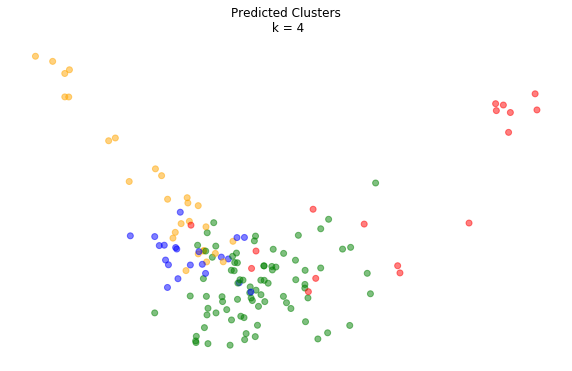

In [50]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [51]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(cocaTFVects.toarray())

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [52]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

In [53]:
X = cocaTFVects.toarray()
plotSilhouette(3, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 3, The average silhouette_score is : 0.017


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


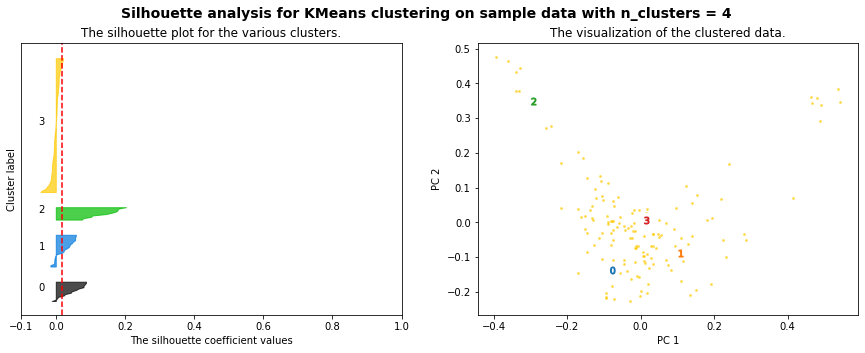

For n_clusters = 4, The average silhouette_score is : 0.017


In [54]:
X = cocaTFVects.toarray()
plotSilhouette(4, X)

In [55]:
X = cocaTFVects.toarray()
plotSilhouette(5, X)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


For n_clusters = 5, The average silhouette_score is : 0.023


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


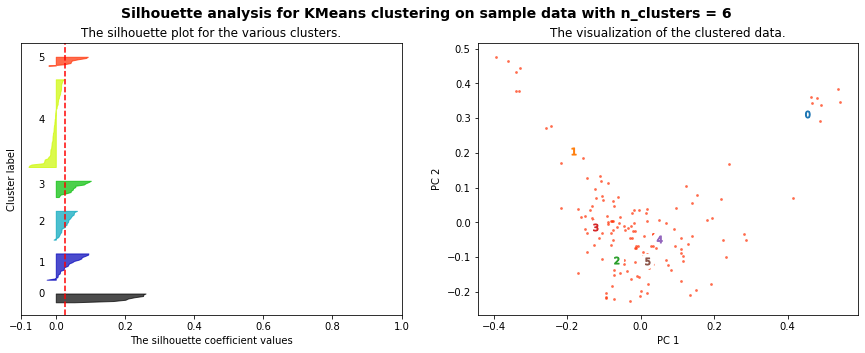

For n_clusters = 6, The average silhouette_score is : 0.026


In [56]:
X = cocaTFVects.toarray()
plotSilhouette(6, X)

The silhouette score suggests that 6 is the correct number of clusters for my corpus, meaning my corpora can be separated into 6 unique "categories." Looking at the words with the highest tf-idf in each cluster, I could approximately label these clusters as - Music
Financial news
Other
Art
Nature
Political news

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

I'm using silhoutte because I don't have ground truth clusters, as I am only using texts from the "spoken" genre as of now. 

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [109]:
newsgroupsTFVects

<2350x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 55644 stored elements in Compressed Sparse Row format>

In [110]:
newsgroupsTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.02540991, ..., 0.00684522, 0.00362269,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [69]:
cocaTFVects[:100].todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.04891599, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.07921329, 0.05601291, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.00754817, 0.00800614, 0.        , ..., 0.        , 0.00836612,
         0.        ]])

In [111]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [71]:
cocaCoocMat = cocaTFVects * cocaTFVects.T
cocaCoocMat.setdiag(0)


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [112]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:10]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [113]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [114]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[ 43.        ,  45.        ,   0.        ,   2.        ],
       [ 48.        , 200.        ,   0.        ,   3.        ],
       [176.        , 201.        ,   0.        ,   4.        ],
       [105.        , 202.        ,   0.37033177,   5.        ],
       [ 19.        , 154.        ,   0.40914841,   2.        ],
       [110.        , 144.        ,   0.44134524,   2.        ],
       [ 12.        , 149.        ,   0.45096656,   2.        ],
       [  1.        , 204.        ,   0.4553535 ,   3.        ],
       [167.        , 206.        ,   0.4650683 ,   3.        ],
       [102.        , 146.        ,   0.46944808,   2.        ]])

Now we can visualize the tree

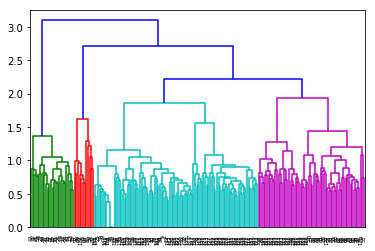

In [115]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

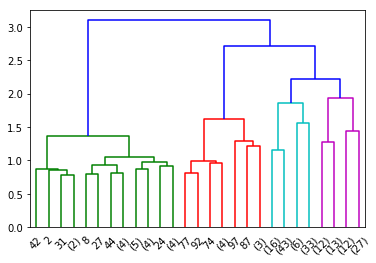

In [116]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [117]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

array([4, 3, 1, 1, 1, 3, 3, 3, 1, 3, 3, 1, 3, 1, 3, 1, 1, 1, 3, 3, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 3, 3, 3, 4, 3, 3, 1, 1, 3,
       1, 3, 3, 1, 3, 4, 4, 4, 1, 4, 4, 4, 4, 2, 4, 4, 3, 4, 4, 4, 4, 4,
       3, 4, 2, 4, 4, 4, 3, 2, 2, 2, 4, 2, 4, 4, 3, 4, 2, 4, 4, 4, 4, 2,
       3, 2, 4, 4, 2, 4, 4, 4, 4, 2, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 4, 4, 4, 3, 3, 4, 4, 4, 3, 4, 4, 4,
       3, 2, 4, 4, 3, 4, 3, 4, 4, 4, 4, 4, 4, 4, 3, 4, 3, 4, 4, 4, 4, 3,
       3, 4], dtype=int32)

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [118]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

For our complete clusters:
Homogeneity: 0.313
Completeness: 0.370
V-measure: 0.339
Adjusted Rand Score: 0.228


Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [119]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

category  \
0     comp.sys.mac.hardware   
1     comp.sys.mac.hardware   
2     comp.sys.mac.hardware   
3     comp.sys.mac.hardware   
4     comp.sys.mac.hardware   
5     comp.sys.mac.hardware   
6     comp.sys.mac.hardware   
7     comp.sys.mac.hardware   
8     comp.sys.mac.hardware   
9     comp.sys.mac.hardware   
10    comp.sys.mac.hardware   
11    comp.sys.mac.hardware   
12    comp.sys.mac.hardware   
13    comp.sys.mac.hardware   
14    comp.sys.mac.hardware   
15    comp.sys.mac.hardware   
16    comp.sys.mac.hardware   
17    comp.sys.mac.hardware   
18    comp.sys.mac.hardware   
19    comp.sys.mac.hardware   
20    comp.sys.mac.hardware   
21    comp.sys.mac.hardware   
22    comp.sys.mac.hardware   
23    comp.sys.mac.hardware   
24    comp.sys.mac.hardware   
25    comp.sys.mac.hardware   
26    comp.sys.mac.hardware   
27    comp.sys.mac.hardware   
28    comp.sys.mac.hardware   
29    comp.sys.mac.hardware   
...                     ...   
2320              rec.autos   
2321              rec.autos   
2322              rec.autos   
2323              rec.autos   
2324              rec.autos   
2325              rec.autos   
2326              rec.autos   
2327              rec.autos   
2328              rec.autos   
2329              rec.autos   
2330              rec.autos   
2331              rec.autos   
2332              rec.autos   
2333              rec.autos   
2334              rec.autos   
2335              rec.autos   
2336              rec.autos   
2337              rec.autos   
2338              rec.autos   
2339              rec.autos   
2340              rec.autos   
2341              rec.autos   
2342              rec.autos   
2343              rec.autos   
2344              rec.autos   
2345              rec.autos   
2346              rec.autos   
2347              rec.autos   
2348              rec.autos   
2349              rec.autos   

                                            source_file  \
0     ../data/scikit_learn_data/20news_home/20news-b...   
1     ../data/scikit_learn_data/20news_home/20news-b...   
2     ../data/scikit_learn_data/20news_home/20news-b...   
3     ../data/scikit_learn_data/20news_home/20news-b...   
4     ../data/scikit_learn_data/20news_home/20news-b...   
5     ../data/scikit_learn_data/20news_home/20news-b...   
6     ../data/scikit_learn_data/20news_home/20news-b...   
7     ../data/scikit_learn_data/20news_home/20news-b...   
8     ../data/scikit_learn_data/20news_home/20news-b...   
9     ../data/scikit_learn_data/20news_home/20news-b...   
10    ../data/scikit_learn_data/20news_home/20news-b...   
11    ../data/scikit_learn_data/20news_home/20news-b...   
12    ../data/scikit_learn_data/20news_home/20news-b...   
13    ../data/scikit_learn_data/20news_home/20news-b...   
14    ../data/scikit_learn_data/20news_home/20news-b...   
15    ../data/scikit_learn_data/20news_home/20news-b...   
16    ../data/scikit_learn_data/20news_home/20news-b...   
17    ../data/scikit_learn_data/20news_home/20news-b...   
18    ../data/scikit_learn_data/20news_home/20news-b...   
19    ../data/scikit_learn_data/20news_home/20news-b...   
20    ../data/scikit_learn_data/20news_home/20news-b...   
21    ../data/scikit_learn_data/20news_home/20news-b...   
22    ../data/scikit_learn_data/20news_home/20news-b...   
23    ../data/scikit_learn_data/20news_home/20news-b...   
24    ../data/scikit_learn_data/20news_home/20news-b...   
25    ../data/scikit_learn_data/20news_home/20news-b...   
26    ../data/scikit_learn_data/20news_home/20news-b...   
27    ../data/scikit_learn_data/20news_home/20news-b...   
28    ../data/scikit_learn_data/20news_home/20news-b...   
29    ../data/scikit_learn_data/20news_home/20news-b...   
...                                                 ...   
2320  ../data/scikit_learn_data/20news_home/20news-b...   
2321  ../data/scikit_learn_data/20news_home/20news-b...   
2322  ../data/scikit_learn_data/20news_home/20news-b...   
2323  ../data/scikit_learn_data

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [120]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)
/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


And visualize the tree:

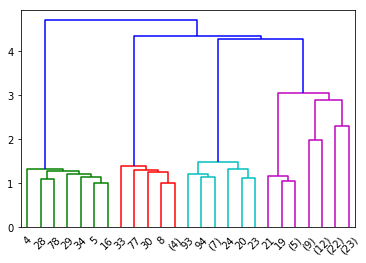

In [121]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [122]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [123]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [124]:
senReleasesTraining[::100]

Unnamed: 0                                       download_url  \
0             0  https://raw.githubusercontent.com/lintool/Grim...   
100         101  https://raw.githubusercontent.com/lintool/Grim...   
200         201  https://raw.githubusercontent.com/lintool/Grim...   
300         301  https://raw.githubusercontent.com/lintool/Grim...   
400         401  https://raw.githubusercontent.com/lintool/Grim...   
500         501  https://raw.githubusercontent.com/lintool/Grim...   
600         601  https://raw.githubusercontent.com/lintool/Grim...   
700         701  https://raw.githubusercontent.com/lintool/Grim...   
800         801  https://raw.githubusercontent.com/lintool/Grim...   
900         901  https://raw.githubusercontent.com/lintool/Grim...   

                                              html_url  \
0    https://github.com/lintool/GrimmerSenatePressR...   
100  https://github.com/lintool/GrimmerSenatePressR...   
200  https://github.com/lintool/GrimmerSenatePressR...   
300  https://github.com/lintool/GrimmerSenatePressR...   
400  https://github.com/lintool/GrimmerSenatePressR...   
500  https://github.com/lintool/GrimmerSenatePressR...   
600  https://github.com/lintool/GrimmerSenatePressR...   
700  https://github.com/lintool/GrimmerSenatePressR...   
800  https://github.com/lintool/GrimmerSenatePressR...   
900  https://github.com/lintool/GrimmerSenatePressR...   

                       name                                path  \
0    01Apr2005Kennedy14.txt  raw/Kennedy/01Apr2005Kennedy14.txt   
100   02Feb2006Kennedy8.txt   raw/Kennedy/02Feb2006Kennedy8.txt   
200   04May2006Kennedy7.txt   raw/Kennedy/04May2006Kennedy7.txt   
300   06Jun2006Kennedy5.txt   raw/Kennedy/06Jun2006Kennedy5.txt   
400   08Dec2006Kennedy4.txt   raw/Kennedy/08Dec2006Kennedy4.txt   
500  09Nov2005Kennedy10.txt  raw/Kennedy/09Nov2005Kennedy10.txt   
600   11Nov2005Kennedy5.txt   raw/Kennedy/11Nov2005Kennedy5.txt   
700   13Jun2006Kennedy0.txt   raw/Kennedy/13Jun2006Kennedy0.txt   
800   15Dec2005Kennedy4.txt   raw/Kennedy/15Dec2005Kennedy4.txt   
900  16May2007Kennedy10.txt  raw/Kennedy/16May2007Kennedy10.txt   

                                                  text targetSenator  \
0             FOR IMMEDIATE RELEASE   FOR IMMEDIATE...       Kennedy   
100           FOR IMMEDIATE RELEASE  Washington  DC...       Kennedy   
200           FOR IMMEDIATE RELEASE      FOR IMMEDI...       Kennedy   
300           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
400           FOR IMMEDIATE RELEASE  Washington  D ...       Kennedy   
500           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
600           FOR IMMEDIATE RELEASE     On this Vet...       Kennedy   
700           FOR IMMEDIATE RELEASE  FOR IMMEDIATE ...       Kennedy   
800           FOR IMMEDIATE RELEASE     Washington ...       Kennedy   
900           FOR IMMEDIATE RELEASE  WASHINGTON  D ...       Kennedy   

     kmeans_predictions                                     tokenized_text  \
0                     1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
100                   2  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
200                   1  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
300                   2  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
400                   1  [FOR, IMMEDIATE, RELEASE, Washington, D, C, To...   
500                   2  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
600                   0  [FOR, IMMEDIATE, RELEASE, On, this, Veteran, s...   
700                   2  [FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, RELE...   
800                   2  [FOR, IMMEDIATE, RELEASE, Washington, DC, Toda...   
900                   2  [FOR, IMMEDIATE, RELEASE, WASHINGTON, D, C, Se...   

                                     normalized_tokens  
0    [immediate, release, immediate, release, conta...  
100  [immediate, release, washington, dc, today, se...  
200  [immediate, release, immediat

In [125]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [126]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [127]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [128]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [129]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [130]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

The topics of the text: 01Apr2005Kennedy14.txt
are: [(3, 0.97342503)]


We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [131]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [132]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

name  \
1    01Aug2005Kennedy12.txt   
101  02Feb2007Kennedy10.txt   
201   04May2006Kennedy8.txt   
301   06Jun2007Kennedy1.txt   
401   08Feb2005Kennedy0.txt   
501  09Nov2005Kennedy11.txt   
601   11Nov2005Kennedy6.txt   
701   13Jun2006Kennedy1.txt   
801   15Dec2005Kennedy5.txt   
901   16May2007Kennedy5.txt   

                                                topics   topic_0  topic_1  \
1    [(0, 0.2372416), (2, 0.48075435), (3, 0.2601182)]  0.237242      0.0   
101  [(0, 0.25670612), (2, 0.074774586), (4, 0.1747...  0.256706      0.0   
201  [(2, 0.18525754), (3, 0.7964857), (5, 0.016392...  0.000000      0.0   
301  [(4, 0.3363582), (7, 0.33487502), (8, 0.288408...  0.000000      0.0   
401  [(0, 0.23246183), (4, 0.54073346), (6, 0.22170...  0.232462      0.0   
501                                  [(3, 0.95548904)]  0.000000      0.0   
601                  [(0, 0.4027371), (9, 0.57299155)]  0.402737      0.0   
701                  [(6, 0.8887102), (9, 0.10867957)]  0.000000      0.0   
801  [(2, 0.71216244), (3, 0.052720606), (4, 0.2194...  0.000000      0.0   
901                   [(4, 0.38913283), (5, 0.569578)]  0.000000      0.0   

      topic_2   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  \
1    0.480754  0.260118  0.000000  0.000000  0.000000  0.000000  0.000000   
101  0.074775  0.000000  0.174717  0.227300  0.000000  0.000000  0.263747   
201  0.185258  0.796486  0.000000  0.016392  0.000000  0.000000  0.000000   
301  0.000000  0.000000  0.336358  0.000000  0.000000  0.334875  0.288408   
401  0.000000  0.000000  0.540733  0.000000  0.221704  0.000000  0.000000   
501  0.000000  0.955489  0.000000  0.000000  0.000000  0.000000  0.000000   
601  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
701  0.000000  0.000000  0.000000  0.000000  0.888710  0.000000  0.000000   
801  0.712162  0.052721  0.219456  0.000000  0.014484  0.000000  0.000000   
901  0.000000  0.000000  0.389133  0.569578  0.000000  0.000000  0.000000   

      topic_9  
1    0.000000  
101  0.000000  
201  0.000000  
301  0.038981  
401  0.000000  
501  0.000000  
601  0.572992  
701  0.108680  
801  0.000000  
901  0.000000

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [133]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

topic_0  topic_1   topic_2   topic_3   topic_4  topic_5   topic_6  \
0  0.000000  0.00000  0.000000  0.973424  0.000000      0.0  0.000000   
1  0.237242  0.00000  0.480754  0.260118  0.000000      0.0  0.000000   
2  0.000000  0.00000  0.000000  0.000000  0.845011      0.0  0.000000   
3  0.000000  0.00000  0.000000  0.971368  0.000000      0.0  0.023263   
4  0.000000  0.00000  0.997682  0.000000  0.000000      0.0  0.000000   
5  0.000000  0.99126  0.000000  0.000000  0.000000      0.0  0.000000   
6  0.424055  0.00000  0.000000  0.000000  0.000000      0.0  0.000000   
7  0.000000  0.00000  0.000000  0.000000  0.000000      0.0  0.000000   
8  0.777248  0.00000  0.000000  0.000000  0.000000      0.0  0.000000   
9  0.000000  0.00000  0.000000  0.000000  0.000000      0.0  0.000000   

   topic_7   topic_8   topic_9  
0      0.0  0.000000  0.000000  
1      0.0  0.000000  0.000000  
2      0.0  0.000000  0.148858  
3      0.0  0.000000  0.000000  
4      0.0  0.000000  0.000000  
5      0.0  0.000000  0.000000  
6      0.0  0.566705  0.000000  
7      0.0  0.000000  0.967543  
8      0.0  0.000000  0.209109  
9      0.0  0.000000  0.967552

First we can visualize as a stacked bar chart:

In [134]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [135]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [136]:
senlda.show_topic(1)

[('wage', 0.0116434805),
 ('minimum', 0.008390752),
 ('worker', 0.007633167),
 ('fund', 0.0046470957),
 ('tax', 0.0031555935),
 ('ireland', 0.003118962),
 ('chip', 0.0030401899),
 ('fda', 0.002955216),
 ('northern', 0.0028156748),
 ('pension', 0.002781847)]

And if we want to make a dataFrame:

In [137]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

Topic_0   Topic_1   Topic_2  Topic_3      Topic_4    Topic_5  Topic_6  \
0        fund      wage    worker     fund       worker      troop     fund   
1     minimum   minimum      fund   worker         head       fund    judge   
2        wage    worker      wage   liheap      pension     worker     wage   
3      worker      fund      loan     cell         fund    teacher     loan   
4        loan       tax     train  minimum         loan  immigrant   worker   
5     company   ireland     woman     stem       lender       fail  company   
6    attorney      chip   teacher     wage        unite      judge   agency   
7       unite       fda   minimum     food  immigration    soldier  teacher   
8  bankruptcy  northern  employer   victim       agency       sick  science   
9    document   pension   pension   winter      company       send      fda   

       Topic_7   Topic_8    Topic_9  
0  immigration    worker       loan  
1         fund      fund     worker  
2       worker     troop    company  
3     asbestos     unite        fda  
4         head      wage       fund  
5        unite     judge     lender  
6         loan  medicare        aid  
7       victim   company       head  
8       border  employee  insurance  
9    immigrant     iraqi     follow

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [138]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

<Figure size 432x288 with 0 Axes>

See how different $\eta$ values can change the shape of the distribution.

In [139]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

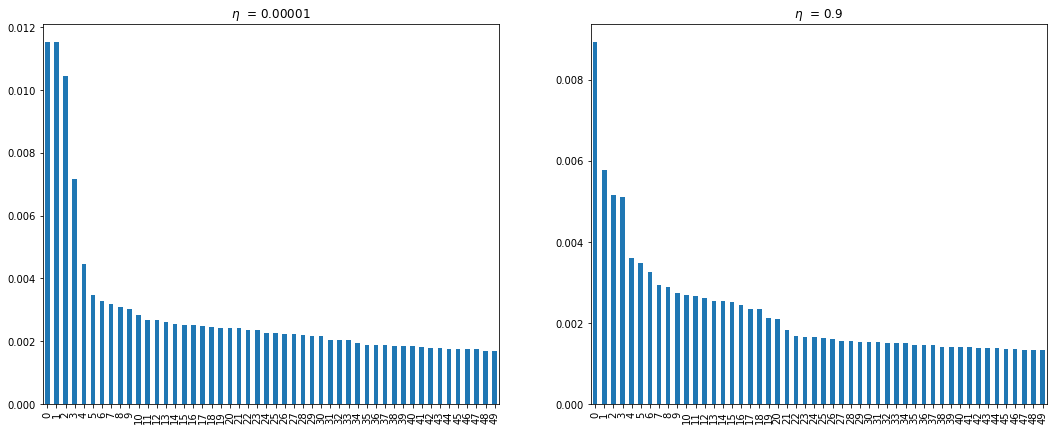

In [140]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [141]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [142]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_7-jss.zip
text_6-egn.zip
text_5-rag.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_8-sbo.zip
text_9-jtw.zip
text_0-tez.zip
text_1-teh.zip


In [143]:
import zipfile
import pandas as pd

In [144]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [145]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [146]:
soap_dict = {}

In [147]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [148]:
soap_dict.keys()

dict_keys(['One Life to Live', 'Guiding Light', 'Passions', 'Young and Restless', 'As the World Turns', 'General Hospital', 'All My Childen', 'Port Charles', 'Bold and Beautiful', 'Days of Our Lives'])

In [149]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [150]:
i = 0

In [151]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

One Life to Live
Guiding Light
Passions
Young and Restless
As the World Turns
General Hospital
All My Childen
Port Charles
Bold and Beautiful
Days of Our Lives


In [152]:
soap_df

Soap Name                                    Tokenized Texts
0    One Life to Live  [@!Rae, What, She, even, has, a, new, friend, ...
1       Guiding Light  [@!Reva, Well, it, 's, very, peaceful, Your, b...
2            Passions  [@!Kay, Going, to, get, pregnant, and, I, 'm, ...
3  Young and Restless  [@!Sharon, Yeah, I, could, n't, sleep, @!Victo...
4  As the World Turns  [@!Katie, Simon, where, are, you, @!Simon, Kat...
5    General Hospital  [@!Stefan, I, love, her, @!Jax, No, Cassadine,...
6      All My Childen  [@!Liza, You, 're, in, early, @!Ryan, Yeah, I,...
7        Port Charles  [@!Jack, There, you, are, you, son, @!Chris, H...
8  Bold and Beautiful  [@!Morgan, What, 's, the, matter, Stephanie, Y...
9   Days of Our Lives  [@!Philip, Seems, like, every, time, I, look, ...

Checking to see which index I should use. In my example it is the last one, so I choose my index as 9. It might be different for you!

In [153]:
dool = soap_df['Tokenized Texts'][9]

In [154]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

In [155]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [156]:
import networkx as nx

In [157]:
actor_network = nx.Graph()

In [158]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [159]:
i = 0

In [160]:
all_texts = []

In [161]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [162]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [163]:
all_texts[0:10]

[['like', 'time', 'look', 'tonight', 'cry'],
 ['carve', 'initial', 'tree'],
 ['deserve', 'get', 'realize', 'special'],
 ['oh', 'half', 'true'],
 ['oh', 'chloe', 'want', 'forever', 'true', 'true', 'normal', 'life'],
 ['great', 'concentrate', 'search', 'downriver', 'work', 'way'],
 ['right', 'underwater'],
 [],
 ['have', 'come', 'soon', 'hear'],
 ['know', 'guy', 'okay']]

In [164]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [165]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [166]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [167]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [168]:
doollda.show_topics()

[(0,
  '0.130*"na" + 0.120*"gon" + 0.090*"be" + 0.042*"love" + 0.028*"wait" + 0.025*"hmm" + 0.021*"say" + 0.018*"mm" + 0.017*"carrie" + 0.016*"mmm"'),
 (1,
  '0.070*"like" + 0.038*"talk" + 0.036*"dad" + 0.033*"time" + 0.032*"try" + 0.027*"chuckle" + 0.025*"be" + 0.023*"look" + 0.023*"listen" + 0.020*"gun"'),
 (2,
  '0.124*"know" + 0.068*"think" + 0.060*"want" + 0.051*"tell" + 0.025*"go" + 0.016*"come" + 0.014*"be" + 0.013*"mean" + 0.013*"happen" + 0.012*"sami"'),
 (3,
  '0.044*"good" + 0.035*"mean" + 0.031*"think" + 0.028*"stefano" + 0.028*"know" + 0.024*"thing" + 0.021*"believe" + 0.020*"like" + 0.017*"way" + 0.015*"lucas"'),
 (4,
  '0.091*"need" + 0.056*"rafe" + 0.053*"help" + 0.030*"course" + 0.029*"leave" + 0.022*"sydney" + 0.022*"test" + 0.021*"bye" + 0.020*"shoot" + 0.020*"ej"'),
 (5,
  '0.133*"yes" + 0.076*"be" + 0.041*"sorry" + 0.037*"get" + 0.026*"know" + 0.020*"well" + 0.014*"feel" + 0.012*"worry" + 0.010*"mean" + 0.010*"glad"'),
 (6,
  '0.063*"john" + 0.059*"stop" + 0.035*"n

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [169]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [170]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

[(0, 0.04434908), (1, 0.1636655), (2, 0.17168337), (3, 0.07303326), (5, 0.18090375), (7, 0.16316645), (8, 0.049669832), (9, 0.15352708)]
[(0, 0.04564287), (1, 0.15994014), (2, 0.166935), (3, 0.07172846), (5, 0.18492804), (7, 0.16686365), (8, 0.052410174), (9, 0.15154955)]
[(0, 0.045564834), (1, 0.161894), (2, 0.16576263), (3, 0.068994306), (5, 0.18667614), (7, 0.18113962), (8, 0.048315547), (9, 0.14165114)]
[(0, 0.051611815), (1, 0.1611779), (2, 0.1781671), (3, 0.07053677), (5, 0.1791648), (7, 0.16717589), (8, 0.048152395), (9, 0.14401132)]
[(0, 0.047252756), (1, 0.16661952), (2, 0.17018682), (3, 0.06864313), (5, 0.18384352), (7, 0.16521569), (8, 0.05054304), (9, 0.14769368)]
[(0, 0.046162076), (1, 0.15438502), (2, 0.16620177), (3, 0.07256862), (5, 0.1968395), (7, 0.16062519), (8, 0.053342965), (9, 0.14987314)]
[(0, 0.04524269), (1, 0.16827387), (2, 0.17442298), (3, 0.07023772), (5, 0.1848608), (7, 0.16046369), (8, 0.04732241), (9, 0.1491746)]
[(0, 0.045984045), (1, 0.16086726), (2, 0.

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [171]:
from gensim.matutils import kullback_leibler

In [172]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [173]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

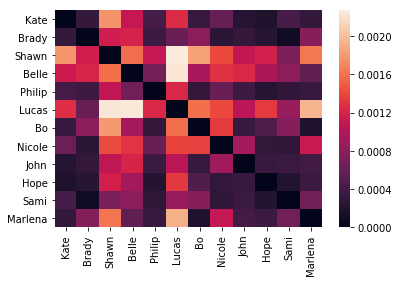

In [174]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [4]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [5]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

text_1940s_bsw.zip
text_1920s_gte.zip
text_1900s_mse.zip
text_1810s_kso.zip
text_2000s_scc.zip
text_1910s_jue.zip
text_1890s_jsq.zip
text_1870s_vuy.zip
text_1840s_nsq.zip
text_1860s_psi.zip
text_1950s_ndz.zip
text_1820s_jsi.zip
text_1980s_bkk.zip
text_1930s_bie.zip
text_1960s_xus.zip
text_1990s_bsj.zip
text_1830s_bsu.zip
text_1850s_jpr.zip
text_1970s_jfy.zip
text_1880s_azz.zip


In [6]:
list(coha_texts.keys())[0:5]

['mag_1942_151505.txt',
 'mag_1925_300619.txt',
 'mag_1973_479429.txt',
 'mag_2004_365045.txt',
 'mag_1929_254298.txt']

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [7]:
coha_genres = {}
coha_years = {}

In [8]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [9]:
coha_genres.keys()

dict_keys(['nf', 'mag', 'fic', 'news'])

In [10]:
coha_years.keys()

dict_keys(['1979', '2007', '1989', '1893', '1968', '1887', '1931', '1976', '1918', '1815', '1860', '1852', '1953', '1847', '2001', '1901', '1912', '1826', '1883', '1881', '2000', '1853', '1892', '1999', '1867', '1914', '1869', '1898', '1973', '1975', '1839', '2004', '1928', '1814', '1909', '1950', '1840', '1832', '1831', '1819', '1991', '1998', '1955', '1990', '1904', '1871', '1897', '1866', '1994', '1945', '1923', '1829', '1873', '1811', '1978', '1921', '1838', '1825', '1844', '1878', '1907', '1886', '1882', '1995', '1967', '1888', '1925', '1980', '1834', '2006', '1966', '1818', '1992', '1957', '1870', '1939', '1824', '1963', '1900', '1876', '1920', '1910', '1937', '1863', '1948', '1954', '1961', '1880', '1848', '1922', '2008', '1938', '1810', '1817', '1842', '1919', '1851', '1895', '1956', '1891', '1997', '1841', '1983', '1969', '1982', '1959', '1971', '1822', '1865', '1859', '2003', '1924', '1916', '1812', '1947', '1855', '1902', '1885', '1868', '1934', '1827', '1843', '1970', '1930

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [11]:
import collections

In [12]:
years = []
year_lens = []

In [13]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [14]:
years[0], years[-1]

('1810', '2009')

In [15]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: there are far less articles in the beginning, and then it grows. Maybe in our 5 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [16]:
all_texts_coha = []
docs_per_timeslice = [0, 0, 0, 0, 0]
i = 0

In [17]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        try:
            if len(article[2]) < 1500000:
                all_texts_coha.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
            if len(article[2]) >= 1500000:
                large_files += 1
        except IndexError:
            continue
    # these numbers are the number of years in the 
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size. You are welcome to try different sizes until you get the size you would like.
I am using a 100 documents per time slice for this example.

In [18]:
def choose_n(corpus, time_slices, nums=100):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

Now, COHA also has some really large files, full books and the like: we're going to now split up really large files such that each of the documents are only 1000 tokens long. This function will return a split up document and the number of files it has been split into, so we can accordingly adjust the documents per time slice, which is important for Dynamic Topic Modelling to work.

In [19]:
def split_up(document, doc_size=1000):
    new_docs = [document[i:i + doc_size] for i in range(0, len(document), doc_size)]
    return(new_docs, len(new_docs))

In [20]:
small_corpus = choose_n(all_texts_coha, docs_per_year, nums=100)

In [41]:
final_corpus= []

In [42]:
docs_per_time_slice = [0, 0, 0, 0, 0]

I now use the split method to create my final corpus. Note that I hardcode values for the time slice to figure out the number of documets per time slice. Now I have a representative number of documents in each time slice. 

In [43]:
for i, article in enumerate(small_corpus):
    # identify time slice based on article number 
    if i < 100:
        time = 0
    if i > 100 and i <= 200:
        time = 1
    if i > 200 and i <= 300:
        time = 2
    if i > 300 and i <= 400:
        time = 3
    if i > 400 and i <= 500:
        time = 4
        
    if len(article) > 1000:
        split_docs, no_docs = split_up(article)
        for doc in split_docs:
            final_corpus.append(doc)
        docs_per_time_slice[time] += no_docs
    else:
        final_corpus.append(article)
        docs_per_time_slice[time] += 1
    # just a check if the counts are correctly added
    if np.sum(docs_per_time_slice) != len(final_corpus):
        print(np.sum(docs_per_time_slice), len(final_corpus))

In [46]:
dictionary = gensim.corpora.Dictionary(final_corpus)

In [47]:
corpus = [dictionary.doc2bow(text) for text in final_corpus]

In [48]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

In [49]:
from gensim.models import ldaseqmodel

In [55]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=4)

/Users/bhargavvader/open_source/Content-Analysis-2020/venv/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [64]:
ldaseq.print_topics(time=0)[1]

[('state', 0.009231335276472926),
 ('man', 0.007395542533241843),
 ('great', 0.005407621887489939),
 ('power', 0.00466463108865709),
 ('time', 0.004145275353013492),
 ('government', 0.0038469615335645527),
 ('mr', 0.003784442892543364),
 ('people', 0.0034467994219777665),
 ('law', 0.0034071786078579145),
 ('new', 0.0030027721654430216),
 ('war', 0.002999489239112416),
 ('say', 0.0029620122071219437),
 ('year', 0.0027265764876598106),
 ('country', 0.0026961884570141158),
 ('general', 0.0026385043499987542),
 ('subject', 0.0025921116091278027),
 ('unite', 0.00243013848020865),
 ('interest', 0.0023961925608540803),
 ('mean', 0.002356244385602689),
 ('present', 0.002327481410279418)]

In [65]:
 ldaseq.print_topics(time=4)[1]

[('state', 0.009063458198506274),
 ('great', 0.005281951052175197),
 ('man', 0.0048113539761249395),
 ('power', 0.004484111341699211),
 ('time', 0.004380730260383426),
 ('mr', 0.004363448261206658),
 ('war', 0.0036676379920160007),
 ('government', 0.003660707892751022),
 ('law', 0.003608034898098456),
 ('people', 0.0035690690199701143),
 ('say', 0.0033669920336640846),
 ('new', 0.003254656714598662),
 ('year', 0.0030063559964820033),
 ('right', 0.002722402127793679),
 ('country', 0.0026929936555686994),
 ('unite', 0.0026207546725993914),
 ('president', 0.0026030905455171633),
 ('general', 0.0025967928515510286),
 ('subject', 0.002447981517223704),
 ('office', 0.0024042338715986418)]

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. In the above model I can see how the topic related to state evolves slowly, with the word president not previously there coming into the topic. I will now save this model and also upload it on GitHub so that you can see how it works. Note that the Dynamic Topic Model is a very time consuming algorithm: you might want to start a run overnight if you intend on using it in your analysis.

In [66]:
ldaseq.save("ldaseqmodel")

In [68]:
loaded_model = ldaseqmodel.LdaSeqModel.load("ldaseqmodel")



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)